In [2]:
# Cell 1: Import Libraries and Setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import (
    EfficientNetV2B0,
    MobileNetV3Large,
    DenseNet121,
    ConvNeXtTiny,
    NASNetMobile
)
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import time
import pandas as pd

# Scikit-learn for metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)

# Check TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

TensorFlow version: 2.20.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Cell 2: Configuration
DATA_DIR = Path("./dataset-aug")  # Use augmented dataset for training
TEST_DIR = Path("./dataset_test")
RESULTS_DIR = Path("./results")  # Base results directory
BATCH_SIZE = 8
EPOCHS = 5
SEED = 42
VALIDATION_SPLIT = 0.2

# Helper functions for organized output paths
def get_model_dir(model_name: str) -> Path:
    """Get model save directory: results/{model_name}/models/"""
    path = RESULTS_DIR / model_name / "models"
    path.mkdir(parents=True, exist_ok=True)
    return path

def get_figures_dir(model_name: str) -> Path:
    """Get figures save directory: results/{model_name}/figures/"""
    path = RESULTS_DIR / model_name / "figures"
    path.mkdir(parents=True, exist_ok=True)
    return path

def get_reports_dir(model_name: str) -> Path:
    """Get reports save directory: results/{model_name}/reports/"""
    path = RESULTS_DIR / model_name / "reports"
    path.mkdir(parents=True, exist_ok=True)
    return path

def get_comparison_dir() -> Path:
    """Get comparison directory for multi-model comparison outputs."""
    path = RESULTS_DIR / "_comparison"
    path.mkdir(parents=True, exist_ok=True)
    return path

# Resolve test directory (optional)
if not TEST_DIR.exists():
    alt_test_dir = DATA_DIR / "test"
    TEST_DIR = alt_test_dir if alt_test_dir.exists() else None

if TEST_DIR is None:
    print("Test dataset directory not found; test_ds will be skipped.")
else:
    print(f"Using test dataset directory: {TEST_DIR.resolve()}")

# Model input sizes (some models have fixed requirements)
MODEL_CONFIG = {
    "EfficientNetV2B0": {"input_size": (224, 224), "preprocess": tf.keras.applications.efficientnet_v2.preprocess_input},
    "MobileNetV3Large": {"input_size": (224, 224), "preprocess": tf.keras.applications.mobilenet_v3.preprocess_input},
    "DenseNet121": {"input_size": (224, 224), "preprocess": tf.keras.applications.densenet.preprocess_input},
    "ConvNeXtTiny": {"input_size": (224, 224), "preprocess": tf.keras.applications.convnext.preprocess_input},
    "NASNetMobile": {"input_size": (224, 224), "preprocess": tf.keras.applications.nasnet.preprocess_input},
}

# Class names from directory structure
CLASS_NAMES = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])
NUM_CLASSES = len(CLASS_NAMES)
print(f"Classes ({NUM_CLASSES}): {CLASS_NAMES}")
print(f"Results will be saved to: {RESULTS_DIR.resolve()}")

Using test dataset directory: /home/vanthkrab/PycharmProjects/BP-Monitor/learning/cnn/lab4-2/dataset_test
Classes (5): ['Allwell', 'Lifebox', 'Omron', 'Sinocare', 'Yuwell']
Results will be saved to: /home/vanthkrab/PycharmProjects/BP-Monitor/learning/cnn/lab4-2/results


In [4]:
# Cell 3: Data Loading Function
def load_dataset(input_size, preprocess_fn=None):
    """Load dataset with specific input size and preprocessing."""
    
    # Load training dataset
    train_ds = image_dataset_from_directory(
        DATA_DIR,
        validation_split=VALIDATION_SPLIT,
        subset="training",
        seed=SEED,
        image_size=input_size,
        batch_size=BATCH_SIZE,
        label_mode="categorical"
    )
    
    # Load validation dataset
    val_ds = image_dataset_from_directory(
        DATA_DIR,
        validation_split=VALIDATION_SPLIT,
        subset="validation",
        seed=SEED,
        image_size=input_size,
        batch_size=BATCH_SIZE,
        label_mode="categorical"
    )
    
    # Optionally load test dataset
    test_ds = None
    if TEST_DIR is not None:
        test_ds = image_dataset_from_directory(
            TEST_DIR,
            image_size=input_size,
            batch_size=BATCH_SIZE,
            shuffle=False,
            label_mode="categorical"
        )
    
    # Get class names
    class_names = train_ds.class_names
    print(f"Classes: {class_names}")
    print(f"Training batches: {len(train_ds)}")
    print(f"Validation batches: {len(val_ds)}")
    if test_ds is not None:
        if test_ds.class_names != class_names:
            raise ValueError("Test dataset classes do not match training classes.")
        print(f"Test batches: {len(test_ds)}")
    
    # Data augmentation for training
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ])
    
    # Apply augmentation and preprocessing to training data
    def prepare_train(image, label):
        image = data_augmentation(image, training=True)
        if preprocess_fn:
            image = preprocess_fn(image)
        return image, label
    
    # Apply preprocessing to validation data
    def prepare_val(image, label):
        if preprocess_fn:
            image = preprocess_fn(image)
        return image, label
    
    # Apply preprocessing to test data
    def prepare_test(image, label):
        if preprocess_fn:
            image = preprocess_fn(image)
        return image, label
    
    # Configure for performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.map(prepare_train, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    val_ds = val_ds.map(prepare_val, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    if test_ds is not None:
        test_ds = test_ds.map(prepare_test, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    
    return train_ds, val_ds, test_ds, class_names

In [5]:
# Cell 4: Model Builder Functions
def build_efficientnetv2b0(num_classes, input_size):
    """Build EfficientNetV2B0 model."""
    base_model = EfficientNetV2B0(
        include_top=False,
        weights="imagenet",
        input_shape=(*input_size, 3),
        pooling="avg"
    )
    base_model.trainable = False  # Freeze base model initially
    
    inputs = keras.Input(shape=(*input_size, 3))
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs, outputs, name="EfficientNetV2B0")
    return model, base_model


def build_mobilenetv3large(num_classes, input_size):
    """Build MobileNetV3Large model."""
    base_model = MobileNetV3Large(
        include_top=False,
        weights="imagenet",
        input_shape=(*input_size, 3),
        pooling="avg"
    )
    base_model.trainable = False
    
    inputs = keras.Input(shape=(*input_size, 3))
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs, outputs, name="MobileNetV3Large")
    return model, base_model


def build_densenet121(num_classes, input_size):
    """Build DenseNet121 model."""
    base_model = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_shape=(*input_size, 3),
        pooling="avg"
    )
    base_model.trainable = False
    
    inputs = keras.Input(shape=(*input_size, 3))
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs, outputs, name="DenseNet121")
    return model, base_model


def build_convnexttiny(num_classes, input_size):
    """Build ConvNeXtTiny model."""
    base_model = ConvNeXtTiny(
        include_top=False,
        weights="imagenet",
        input_shape=(*input_size, 3),
        pooling="avg"
    )
    base_model.trainable = False
    
    inputs = keras.Input(shape=(*input_size, 3))
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs, outputs, name="ConvNeXtTiny")
    return model, base_model


def build_nasnetmobile(num_classes, input_size):
    """Build NASNetMobile model."""
    base_model = NASNetMobile(
        include_top=False,
        weights="imagenet",
        input_shape=(*input_size, 3),
        pooling="avg"
    )
    base_model.trainable = False
    
    inputs = keras.Input(shape=(*input_size, 3))
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs, outputs, name="NASNetMobile")
    return model, base_model


# Dictionary mapping model names to builder functions
MODEL_BUILDERS = {
    "EfficientNetV2B0": build_efficientnetv2b0,
    "MobileNetV3Large": build_mobilenetv3large,
    "DenseNet121": build_densenet121,
    "ConvNeXtTiny": build_convnexttiny,
    "NASNetMobile": build_nasnetmobile,
}

In [6]:
# Cell 5: Training Function with Time Tracking
def train_model(model_name, num_classes, epochs=EPOCHS, fine_tune_epochs=20):
    """Train a model with transfer learning and fine-tuning. Returns training time."""
    fine_tune_epochs=5
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    # Get model configuration
    config = MODEL_CONFIG[model_name]
    input_size = config["input_size"]
    preprocess_fn = config["preprocess"]
    
    # Load dataset
    train_ds, val_ds, test_ds, class_names = load_dataset(input_size, preprocess_fn)
    
    # Build model
    build_fn = MODEL_BUILDERS[model_name]
    model, base_model = build_fn(num_classes, input_size)
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    model.summary()
    
    # Get model save directory
    model_dir = get_model_dir(model_name)
    
    # Callbacks
    callbacks = [
        ModelCheckpoint(
            str(model_dir / f"best_{model_name}.keras"),
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
            verbose=1
        ),
        EarlyStopping(
            monitor="val_accuracy",
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Start timing
    start_time = time.time()
    
    # Phase 1: Train with frozen base
    print(f"\n--- Phase 1: Training top layers (base frozen) ---")
    history1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Phase 2: Fine-tuning (unfreeze some layers)
    print(f"\n--- Phase 2: Fine-tuning ---")
    base_model.trainable = True
    
    # Freeze early layers, only train later layers
    fine_tune_at = len(base_model.layers) // 2
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # Recompile with lower learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Update checkpoint path for fine-tuning
    callbacks[0] = ModelCheckpoint(
        str(model_dir / f"best_{model_name}_finetuned.keras"),
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
        verbose=1
    )
    
    history2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=fine_tune_epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # End timing
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"\nTotal Training Time for {model_name}: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
    print(f"Model saved to: {model_dir}")
    
    # Combine histories
    history = {
        "accuracy": history1.history["accuracy"] + history2.history["accuracy"],
        "val_accuracy": history1.history["val_accuracy"] + history2.history["val_accuracy"],
        "loss": history1.history["loss"] + history2.history["loss"],
        "val_loss": history1.history["val_loss"] + history2.history["val_loss"],
    }
    
    return model, history, class_names, training_time, val_ds, test_ds

In [7]:
# Cell 6: Visualization and Metrics Functions
def plot_training_history(history, model_name):
    """Plot training and validation accuracy/loss."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(history["accuracy"], label="Train Accuracy", linewidth=2)
    axes[0].plot(history["val_accuracy"], label="Val Accuracy", linewidth=2)
    axes[0].set_title(f"{model_name} - Accuracy", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("Epoch", fontsize=12)
    axes[0].set_ylabel("Accuracy", fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(history["loss"], label="Train Loss", linewidth=2)
    axes[1].plot(history["val_loss"], label="Val Loss", linewidth=2)
    axes[1].set_title(f"{model_name} - Loss", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Epoch", fontsize=12)
    axes[1].set_ylabel("Loss", fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save to model's figures directory
    figures_dir = get_figures_dir(model_name)
    plt.savefig(figures_dir / f"train_{model_name}_history.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Training history saved to: {figures_dir}")


def get_predictions(model, dataset):
    """Get true labels and predictions from a dataset."""
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(predictions, axis=1))
    
    return np.array(y_true), np.array(y_pred)


def compute_metrics(y_true, y_pred, class_names):
    """Compute classification metrics."""
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average='macro', zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average='macro', zero_division=0),
        "precision_weighted": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "recall_weighted": recall_score(y_true, y_pred, average='weighted', zero_division=0),
        "f1_weighted": f1_score(y_true, y_pred, average='weighted', zero_division=0),
    }
    
    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    for i, class_name in enumerate(class_names):
        metrics[f"precision_{class_name}"] = precision_per_class[i]
        metrics[f"recall_{class_name}"] = recall_per_class[i]
        metrics[f"f1_{class_name}"] = f1_per_class[i]
    
    return metrics


def plot_confusion_matrix(y_true, y_pred, class_names, model_name, normalize=True):
    """Plot confusion matrix (normalized or not)."""
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = f'{model_name} - Normalized Confusion Matrix'
        suffix = '_normalized'
    else:
        fmt = 'd'
        title = f'{model_name} - Confusion Matrix'
        suffix = ''
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save to model's figures directory
    figures_dir = get_figures_dir(model_name)
    plt.savefig(figures_dir / f"valid_{model_name}_confusion_matrix{suffix}.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    return cm


def evaluate_model(model, model_name, val_ds):
    """Evaluate model and print metrics."""
    results = model.evaluate(val_ds, verbose=1)
    print(f"\n{model_name} - Evaluation Results:")
    print(f"  Loss: {results[0]:.4f}")
    print(f"  Accuracy: {results[1]:.4f}")
    return results


def compare_models(results_dict):
    """Compare all trained models."""
    models = list(results_dict.keys())
    accuracies = [results_dict[m]["accuracy"] for m in models]
    losses = [results_dict[m]["loss"] for m in models]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']
    
    # Accuracy comparison
    bars1 = axes[0].bar(models, accuracies, color=colors, edgecolor='black')
    axes[0].set_title("Model Accuracy Comparison", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("Accuracy", fontsize=12)
    axes[0].set_ylim([0, 1])
    for bar, acc in zip(bars1, accuracies):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                     f'{acc:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Loss comparison
    bars2 = axes[1].bar(models, losses, color=colors, edgecolor='black')
    axes[1].set_title("Model Loss Comparison", fontsize=14, fontweight='bold')
    axes[1].set_ylabel("Loss", fontsize=12)
    for bar, loss in zip(bars2, losses):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                     f'{loss:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    # Save to comparison directory
    comparison_dir = get_comparison_dir()
    plt.savefig(comparison_dir / "valid_model_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()


def save_model_metrics_report(model_name, metrics, class_names, prefix="valid"):
    """Save metrics report to CSV for a single model."""
    reports_dir = get_reports_dir(model_name)
    
    # Summary metrics
    summary_data = {
        "Metric": ["Accuracy", "Precision (Macro)", "Recall (Macro)", "F1-Score (Macro)",
                   "Precision (Weighted)", "Recall (Weighted)", "F1-Score (Weighted)"],
        "Value": [
            metrics["accuracy"], metrics["precision_macro"], metrics["recall_macro"], metrics["f1_macro"],
            metrics["precision_weighted"], metrics["recall_weighted"], metrics["f1_weighted"]
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(reports_dir / f"{prefix}_{model_name}_summary_metrics.csv", index=False)
    
    # Per-class metrics
    per_class_data = {
        "Class": class_names,
        "Precision": [metrics[f"precision_{c}"] for c in class_names],
        "Recall": [metrics[f"recall_{c}"] for c in class_names],
        "F1-Score": [metrics[f"f1_{c}"] for c in class_names],
    }
    per_class_df = pd.DataFrame(per_class_data)
    per_class_df.to_csv(reports_dir / f"{prefix}_{model_name}_per_class_metrics.csv", index=False)
    
    print(f"Reports saved to: {reports_dir}")

## Train All Models
Run the cells below to train each model individually. Each model will be trained with transfer learning (frozen base) followed by fine-tuning.


Training EfficientNetV2B0
Found 5496 files belonging to 5 classes.
Using 4397 files for training.


I0000 00:00:1770202081.437832   12638 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2148 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 5496 files belonging to 5 classes.
Using 1099 files for validation.
Found 100 files belonging to 5 classes.
Classes: ['Allwell', 'Lifebox', 'Omron', 'Sinocare', 'Yuwell']
Training batches: 550
Validation batches: 138
Test batches: 13


Model: "EfficientNetV2B0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,925,717 (22.60 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)


--- Phase 1: Training top layers (base frozen) ---
Epoch 1/5


2026-02-04 17:48:12.940277: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fc5e4003b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-04 17:48:12.940309: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2026-02-04 17:48:13.285820: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-04 17:48:14.522661: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-02-04 17:48:20.115171: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:48:20.225604: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel 

548/550 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7356 - loss: 0.7767

2026-02-04 17:48:40.243535: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:48:40.353332: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:48:41.370282: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:48:41.483530: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7361 - loss: 0.7756

2026-02-04 17:48:57.401475: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:48:57.510927: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:48:58.520521: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:48:58.633315: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from None to 0.98271, saving model to results/EfficientNetV2B0/models/best_EfficientNetV2B0.keras

Epoch 1: finished saving model to results/EfficientNetV2B0/models/best_EfficientNetV2B0.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 56s 62ms/step - accuracy: 0.8647 - loss: 0.4766 - val_accuracy: 0.9827 - val_loss: 0.1962 - learning_rate: 0.0010
Epoch 2/5
546/550 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9627 - loss: 0.1799
Epoch 2: val_accuracy improved from 0.98271 to 0.98362, saving model to results/EfficientNetV2B0/models/best_EfficientNetV2B0.keras

Epoch 2: finished saving model to results/EfficientNetV2B0/models/best_EfficientNetV2B0.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9663 - loss: 0.1612 - val_accuracy: 0.9836 - val_loss: 0.1124 - learning_rate: 0.0010
Epoch 3/5
546/550 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9733 - loss: 0.1263
Epoch 3: val_accuracy improved from 0.98362 to 0.98635, saving model to results/EfficientN

2026-02-04 17:49:59.041665: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:49:59.152748: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


549/550 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8496 - loss: 0.4598

2026-02-04 17:50:28.006915: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:50:28.116449: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8497 - loss: 0.4596
Epoch 1: val_accuracy improved from None to 0.97179, saving model to results/EfficientNetV2B0/models/best_EfficientNetV2B0_finetuned.keras

Epoch 1: finished saving model to results/EfficientNetV2B0/models/best_EfficientNetV2B0_finetuned.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 67s 68ms/step - accuracy: 0.8933 - loss: 0.3579 - val_accuracy: 0.9718 - val_loss: 0.1495 - learning_rate: 1.0000e-05
Epoch 2/5
548/550 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9465 - loss: 0.1967
Epoch 2: val_accuracy improved from 0.97179 to 0.98089, saving model to results/EfficientNetV2B0/models/best_EfficientNetV2B0_finetuned.keras

Epoch 2: finished saving model to results/EfficientNetV2B0/models/best_EfficientNetV2B0_finetuned.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.9466 - loss: 0.1907 - val_accuracy: 0.9809 - val_loss: 0.0830 - learning_rate: 1.0000e-05
Epoch 3/5
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step -

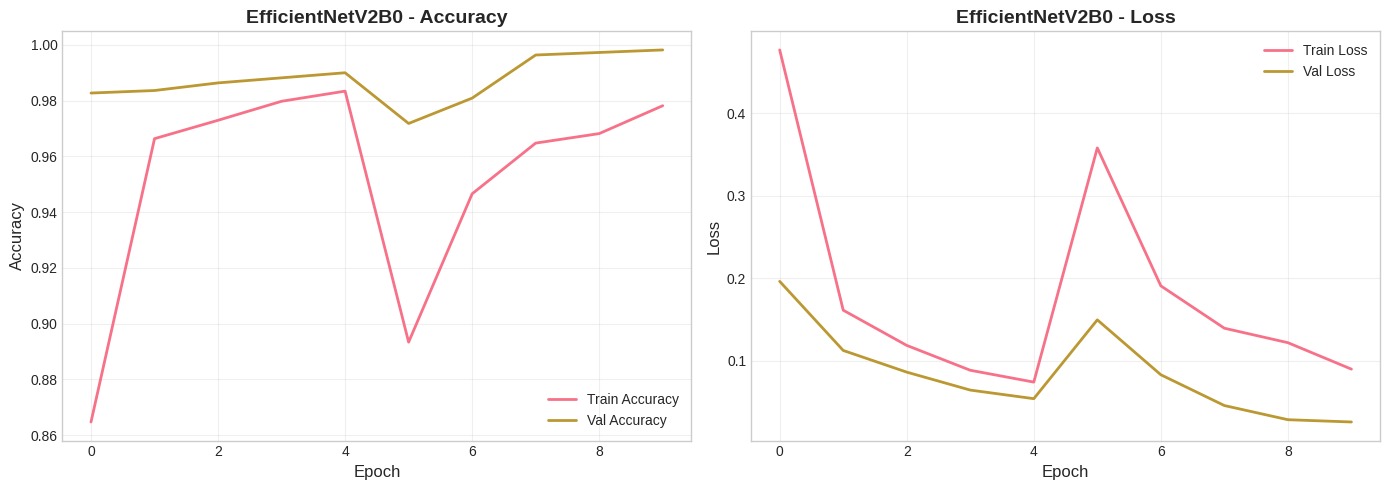

Training history saved to: results/EfficientNetV2B0/figures


In [8]:
# Cell 8: Train EfficientNetV2B0
model_efficientnet, history_efficientnet, class_names, time_efficientnet, val_ds_efficientnet, test_ds_efficientnet = train_model(
    "EfficientNetV2B0", NUM_CLASSES, fine_tune_epochs=20
)
plot_training_history(history_efficientnet, "EfficientNetV2B0")


Training MobileNetV3Large
Found 5496 files belonging to 5 classes.
Using 4397 files for training.
Found 5496 files belonging to 5 classes.
Using 1099 files for validation.
Found 100 files belonging to 5 classes.
Classes: ['Allwell', 'Lifebox', 'Omron', 'Sinocare', 'Yuwell']
Training batches: 550
Validation batches: 138
Test batches: 13


Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         4,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 4,805 (18.77 KB)

 Non-trainable params: 2,996,352 (11.43 MB)


--- Phase 1: Training top layers (base frozen) ---
Epoch 1/5


2026-02-04 17:51:59.721835: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:51:59.833595: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


549/550 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6743 - loss: 0.8881

2026-02-04 17:52:14.562327: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:52:14.673949: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6746 - loss: 0.8873

2026-02-04 17:52:27.767995: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:52:27.879798: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from None to 0.97634, saving model to results/MobileNetV3Large/models/best_MobileNetV3Large.keras

Epoch 1: finished saving model to results/MobileNetV3Large/models/best_MobileNetV3Large.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.8431 - loss: 0.4706 - val_accuracy: 0.9763 - val_loss: 0.1547 - learning_rate: 0.0010
Epoch 2/5
546/550 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9639 - loss: 0.1456
Epoch 2: val_accuracy improved from 0.97634 to 0.98726, saving model to results/MobileNetV3Large/models/best_MobileNetV3Large.keras

Epoch 2: finished saving model to results/MobileNetV3Large/models/best_MobileNetV3Large.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9677 - loss: 0.1322 - val_accuracy: 0.9873 - val_loss: 0.0890 - learning_rate: 0.0010
Epoch 3/5
546/550 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9755 - loss: 0.0981
Epoch 3: val_accuracy improved from 0.98726 to 0.99181, saving model to results/MobileNetV3

2026-02-04 17:53:13.907593: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:53:14.022447: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


547/550 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8714 - loss: 0.3822

2026-02-04 17:53:38.290385: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 17:53:38.403254: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8716 - loss: 0.3818
Epoch 1: val_accuracy improved from None to 0.99363, saving model to results/MobileNetV3Large/models/best_MobileNetV3Large_finetuned.keras

Epoch 1: finished saving model to results/MobileNetV3Large/models/best_MobileNetV3Large_finetuned.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 53s 57ms/step - accuracy: 0.8967 - loss: 0.3032 - val_accuracy: 0.9936 - val_loss: 0.0256 - learning_rate: 1.0000e-05
Epoch 2/5
548/550 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9472 - loss: 0.1527
Epoch 2: val_accuracy did not improve from 0.99363
550/550 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9522 - loss: 0.1402 - val_accuracy: 0.9918 - val_loss: 0.0306 - learning_rate: 1.0000e-05
Epoch 3/5
548/550 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9624 - loss: 0.1239
Epoch 3: val_accuracy did not improve from 0.99363
550/550 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9652 - loss: 0.1188 - val_accuracy: 0.9909 - val_loss: 

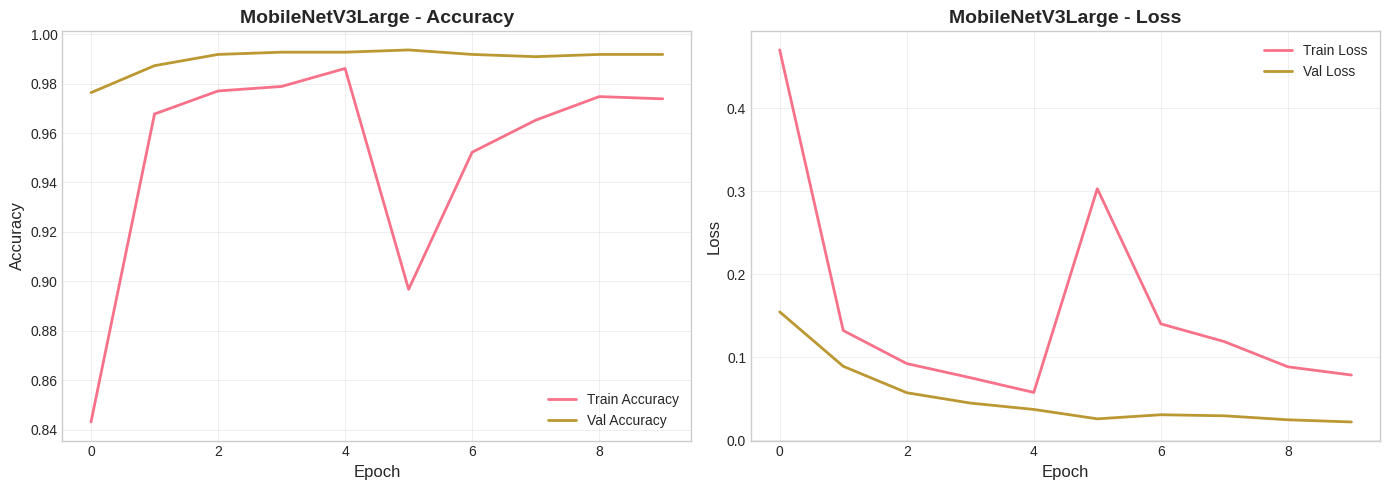

Training history saved to: results/MobileNetV3Large/figures


In [9]:
# Cell 9: Train MobileNetV3Large
model_mobilenet, history_mobilenet, _, time_mobilenet, val_ds_mobilenet, test_ds_mobilenet = train_model(
    "MobileNetV3Large", NUM_CLASSES, fine_tune_epochs=20
)
plot_training_history(history_mobilenet, "MobileNetV3Large")


Training DenseNet121
Found 5496 files belonging to 5 classes.
Using 4397 files for training.
Found 5496 files belonging to 5 classes.
Using 1099 files for validation.
Found 100 files belonging to 5 classes.
Classes: ['Allwell', 'Lifebox', 'Omron', 'Sinocare', 'Yuwell']
Training batches: 550
Validation batches: 138
Test batches: 13


Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,301,189 (27.85 MB)

 Trainable params: 263,685 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)


--- Phase 1: Training top layers (base frozen) ---
Epoch 1/5
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6468 - loss: 0.9918
Epoch 1: val_accuracy improved from None to 0.97725, saving model to results/DenseNet121/models/best_DenseNet121.keras

Epoch 1: finished saving model to results/DenseNet121/models/best_DenseNet121.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.7612 - loss: 0.6613 - val_accuracy: 0.9773 - val_loss: 0.1504 - learning_rate: 0.0010
Epoch 2/5
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8785 - loss: 0.3607
Epoch 2: val_accuracy did not improve from 0.97725
550/550 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.8774 - loss: 0.3571 - val_accuracy: 0.9763 - val_loss: 0.1119 - learning_rate: 0.0010
Epoch 3/5
549/550 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8876 - loss: 0.3189
Epoch 3: val_accuracy improved from 0.97725 to 0.98362, saving model to results/DenseNet121/models/best_DenseNet121.keras

Epoch 3: finished saving m

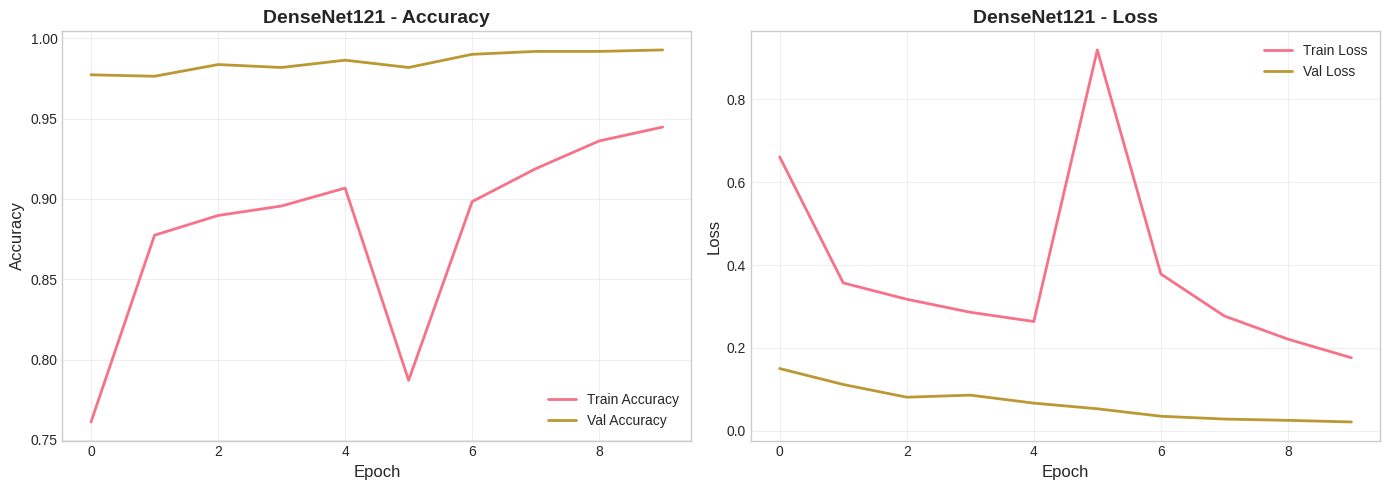

Training history saved to: results/DenseNet121/figures


In [10]:
# Cell 10: Train DenseNet121
model_densenet, history_densenet, _, time_densenet, val_ds_densenet, test_ds_densenet = train_model(
    "DenseNet121", NUM_CLASSES, fine_tune_epochs=20
)
plot_training_history(history_densenet, "DenseNet121")


Training ConvNeXtTiny
Found 5496 files belonging to 5 classes.
Using 4397 files for training.
Found 5496 files belonging to 5 classes.
Using 1099 files for validation.
Found 100 files belonging to 5 classes.
Classes: ['Allwell', 'Lifebox', 'Omron', 'Sinocare', 'Yuwell']
Training batches: 550
Validation batches: 138
Test batches: 13


Model: "ConvNeXtTiny"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 768)            │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         3,845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,823,973 (106.14 MB)

 Trainable params: 3,845 (15.02 KB)

 Non-trainable params: 27,820,128 (106.13 MB)


--- Phase 1: Training top layers (base frozen) ---
Epoch 1/5


2026-02-04 18:01:49.428181: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 16 bytes spill stores, 16 bytes spill loads

2026-02-04 18:01:49.795615: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 64 bytes spill stores, 64 bytes spill loads

2026-02-04 18:01:50.022847: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 64 bytes spill stores, 64 bytes spill loads

2026-02-04 18:01:50.425455: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 64 bytes spill stores, 64 bytes spill loads

2026-02-04 18:01:50.474703: I external/local_xla/

549/550 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6875 - loss: 0.8707

2026-02-04 18:02:13.635068: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 64 bytes spill stores, 64 bytes spill loads

2026-02-04 18:02:13.776527: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 16 bytes spill stores, 16 bytes spill loads

2026-02-04 18:02:13.839689: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 64 bytes spill stores, 64 bytes spill loads

2026-02-04 18:02:13.873217: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 64 bytes spill stores, 64 bytes spill loads

2026-02-04 18:02:13.982684: I external/local_xla/x

550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6878 - loss: 0.8701

2026-02-04 18:02:26.994894: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 16 bytes spill stores, 16 bytes spill loads

2026-02-04 18:02:27.282248: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 64 bytes spill stores, 64 bytes spill loads

2026-02-04 18:02:27.390657: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 4 bytes spill stores, 4 bytes spill loads

2026-02-04 18:02:27.452700: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 64 bytes spill stores, 64 bytes spill loads

2026-02-04 18:02:27.755235: I external/local_xla/xla


Epoch 1: val_accuracy improved from None to 0.95632, saving model to results/ConvNeXtTiny/models/best_ConvNeXtTiny.keras

Epoch 1: finished saving model to results/ConvNeXtTiny/models/best_ConvNeXtTiny.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 50s 69ms/step - accuracy: 0.8181 - loss: 0.5379 - val_accuracy: 0.9563 - val_loss: 0.2170 - learning_rate: 0.0010
Epoch 2/5
549/550 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9367 - loss: 0.2123
Epoch 2: val_accuracy improved from 0.95632 to 0.97088, saving model to results/ConvNeXtTiny/models/best_ConvNeXtTiny.keras

Epoch 2: finished saving model to results/ConvNeXtTiny/models/best_ConvNeXtTiny.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.9450 - loss: 0.1917 - val_accuracy: 0.9709 - val_loss: 0.1494 - learning_rate: 0.0010
Epoch 3/5
549/550 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9610 - loss: 0.1422
Epoch 3: val_accuracy improved from 0.97088 to 0.97634, saving model to results/ConvNeXtTiny/models/best_ConvNeXtTiny.kera

2026-02-04 18:04:11.547431: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 16 bytes spill stores, 16 bytes spill loads

2026-02-04 18:04:12.951383: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 18:04:13.060169: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 18:04:20.718311: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_6', 4 bytes spill stores, 4 bytes spill loads



549/550 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9731 - loss: 0.0701

2026-02-04 18:05:32.897599: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 16 bytes spill stores, 16 bytes spill loads

2026-02-04 18:05:33.737713: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 11660 bytes spill stores, 10372 bytes spill loads

2026-02-04 18:05:34.340470: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 18:05:34.449407: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9731 - loss: 0.0701
Epoch 1: val_accuracy improved from None to 0.99636, saving model to results/ConvNeXtTiny/models/best_ConvNeXtTiny_finetuned.keras

Epoch 1: finished saving model to results/ConvNeXtTiny/models/best_ConvNeXtTiny_finetuned.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 115s 172ms/step - accuracy: 0.9807 - loss: 0.0521 - val_accuracy: 0.9964 - val_loss: 0.0138 - learning_rate: 1.0000e-05
Epoch 2/5
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9952 - loss: 0.0211
Epoch 2: val_accuracy improved from 0.99636 to 0.99727, saving model to results/ConvNeXtTiny/models/best_ConvNeXtTiny_finetuned.keras

Epoch 2: finished saving model to results/ConvNeXtTiny/models/best_ConvNeXtTiny_finetuned.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 74s 134ms/step - accuracy: 0.9943 - loss: 0.0230 - val_accuracy: 0.9973 - val_loss: 0.0083 - learning_rate: 1.0000e-05
Epoch 3/5
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9951 - loss: 

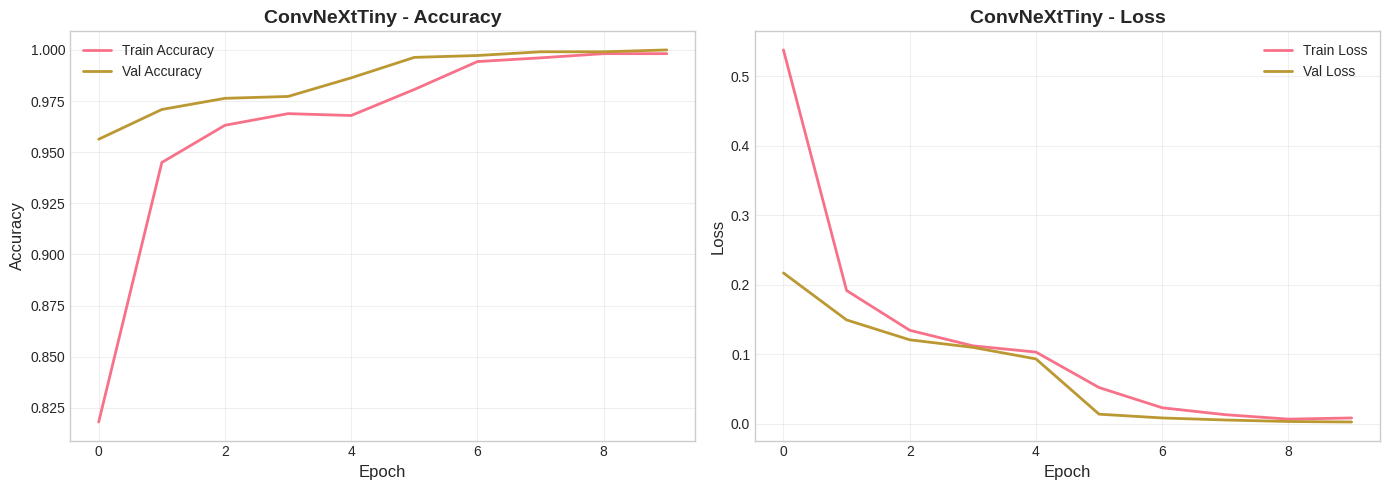

Training history saved to: results/ConvNeXtTiny/figures


In [11]:
# Cell 11: Train ConvNeXtTiny
model_convnext, history_convnext, _, time_convnext, val_ds_convnext, test_ds_convnext = train_model(
    "ConvNeXtTiny", NUM_CLASSES, fine_tune_epochs=20
)
plot_training_history(history_convnext, "ConvNeXtTiny")


Training NASNetMobile
Found 5496 files belonging to 5 classes.
Using 4397 files for training.
Found 5496 files belonging to 5 classes.
Using 1099 files for validation.
Found 100 files belonging to 5 classes.
Classes: ['Allwell', 'Lifebox', 'Omron', 'Sinocare', 'Yuwell']
Training batches: 550
Validation batches: 138
Test batches: 13


Model: "NASNetMobile"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nasnet_mobile (Functional)      │ (None, 1056)           │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1056)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         5,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,275,001 (16.31 MB)

 Trainable params: 5,285 (20.64 KB)

 Non-trainable params: 4,269,716 (16.29 MB)


--- Phase 1: Training top layers (base frozen) ---
Epoch 1/5
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5984 - loss: 1.0568
Epoch 1: val_accuracy improved from None to 0.81711, saving model to results/NASNetMobile/models/best_NASNetMobile.keras

Epoch 1: finished saving model to results/NASNetMobile/models/best_NASNetMobile.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 84s 106ms/step - accuracy: 0.7093 - loss: 0.8070 - val_accuracy: 0.8171 - val_loss: 0.5854 - learning_rate: 0.0010
Epoch 2/5
549/550 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8389 - loss: 0.4920
Epoch 2: val_accuracy improved from 0.81711 to 0.89354, saving model to results/NASNetMobile/models/best_NASNetMobile.keras

Epoch 2: finished saving model to results/NASNetMobile/models/best_NASNetMobile.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.8513 - loss: 0.4592 - val_accuracy: 0.8935 - val_loss: 0.4013 - learning_rate: 0.0010
Epoch 3/5
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8798

2026-02-04 18:14:28.028384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_multiply_slice_fusion_1', 8 bytes spill stores, 8 bytes spill loads



550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6676 - loss: 1.3607
Epoch 1: val_accuracy improved from None to 0.92721, saving model to results/NASNetMobile/models/best_NASNetMobile_finetuned.keras

Epoch 1: finished saving model to results/NASNetMobile/models/best_NASNetMobile_finetuned.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 146s 147ms/step - accuracy: 0.7576 - loss: 0.8398 - val_accuracy: 0.9272 - val_loss: 0.2325 - learning_rate: 1.0000e-05
Epoch 2/5
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8922 - loss: 0.3002
Epoch 2: val_accuracy improved from 0.92721 to 0.94540, saving model to results/NASNetMobile/models/best_NASNetMobile_finetuned.keras

Epoch 2: finished saving model to results/NASNetMobile/models/best_NASNetMobile_finetuned.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.9049 - loss: 0.2736 - val_accuracy: 0.9454 - val_loss: 0.1671 - learning_rate: 1.0000e-05
Epoch 3/5
549/550 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9318 - loss: 0.1

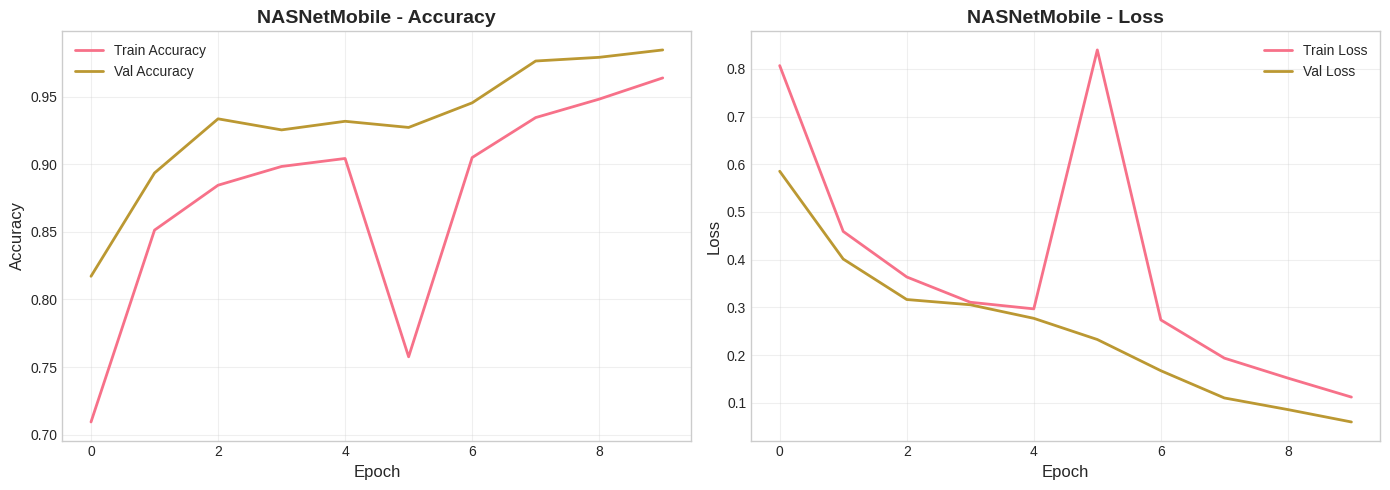

Training history saved to: results/NASNetMobile/figures


In [12]:
# Cell 12: Train NASNetMobile
model_nasnet, history_nasnet, _, time_nasnet, val_ds_nasnet, test_ds_nasnet = train_model(
    "NASNetMobile", NUM_CLASSES, fine_tune_epochs=20
)
plot_training_history(history_nasnet, "NASNetMobile")

## Model Evaluation and Metrics Comparison
### Precision, Recall, F1-Score, Accuracy for all models


Computing metrics for EfficientNetV2B0


2026-02-04 18:18:07.838674: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report for EfficientNetV2B0 (Validation):
              precision    recall  f1-score   support

     Allwell     1.0000    1.0000    1.0000       127
     Lifebox     1.0000    1.0000    1.0000        75
       Omron     0.9980    0.9980    0.9980       502
    Sinocare     1.0000    1.0000    1.0000       196
      Yuwell     0.9950    0.9950    0.9950       199

    accuracy                         0.9982      1099
   macro avg     0.9986    0.9986    0.9986      1099
weighted avg     0.9982    0.9982    0.9982      1099

Reports saved to: results/EfficientNetV2B0/reports


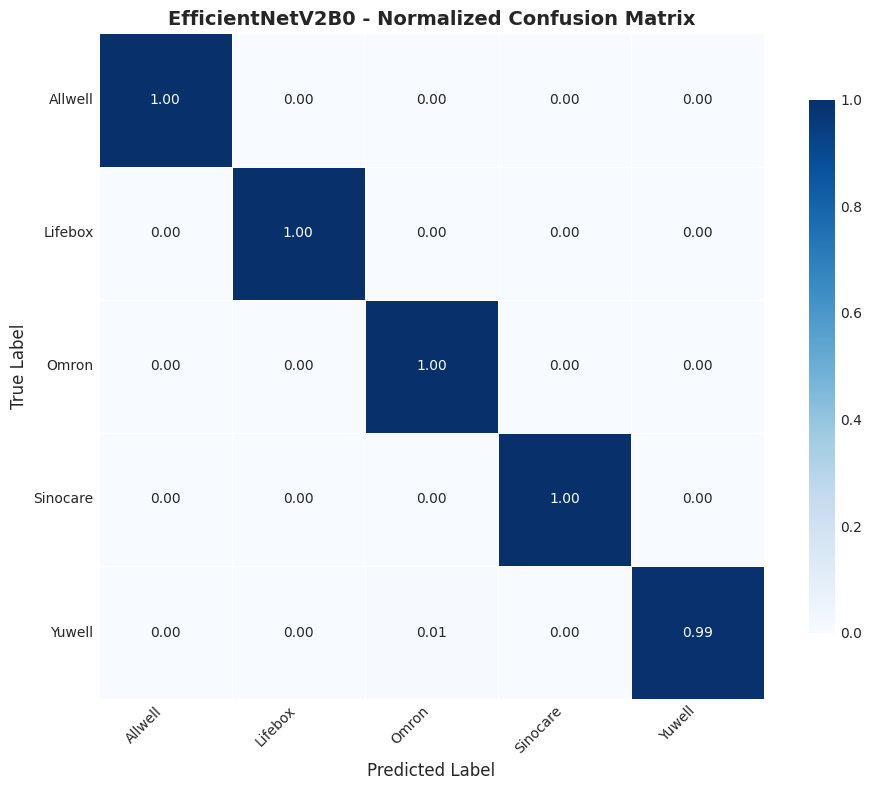

2026-02-04 18:18:13.466884: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 18:18:13.576938: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 18:18:14.598666: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 18:18:14.712235: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 18:18:17.057095: I tensorflow/core/framework/loca

Classification Report for EfficientNetV2B0 (Test):
              precision    recall  f1-score   support

     Allwell     1.0000    1.0000    1.0000        13
     Lifebox     1.0000    1.0000    1.0000         7
       Omron     1.0000    1.0000    1.0000        44
    Sinocare     1.0000    1.0000    1.0000        19
      Yuwell     1.0000    1.0000    1.0000        17

    accuracy                         1.0000       100
   macro avg     1.0000    1.0000    1.0000       100
weighted avg     1.0000    1.0000    1.0000       100

Reports saved to: results/EfficientNetV2B0/reports


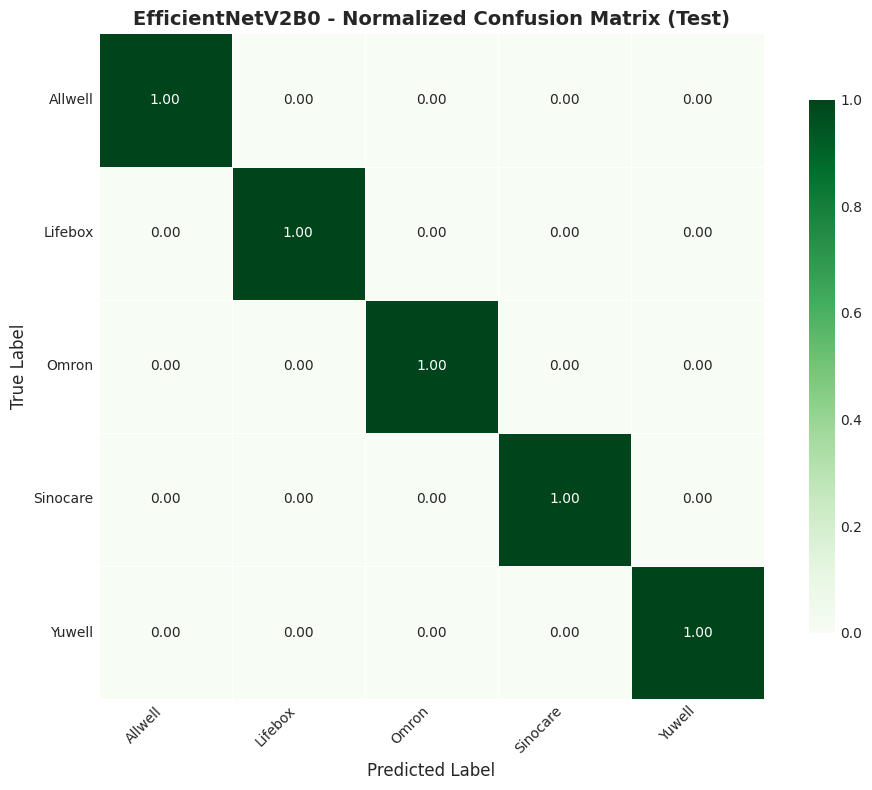


Computing metrics for MobileNetV3Large

Classification Report for MobileNetV3Large (Validation):
              precision    recall  f1-score   support

     Allwell     0.9845    1.0000    0.9922       127
     Lifebox     1.0000    1.0000    1.0000        75
       Omron     0.9960    0.9900    0.9930       502
    Sinocare     1.0000    1.0000    1.0000       196
      Yuwell     0.9850    0.9899    0.9875       199

    accuracy                         0.9936      1099
   macro avg     0.9931    0.9960    0.9945      1099
weighted avg     0.9937    0.9936    0.9936      1099

Reports saved to: results/MobileNetV3Large/reports


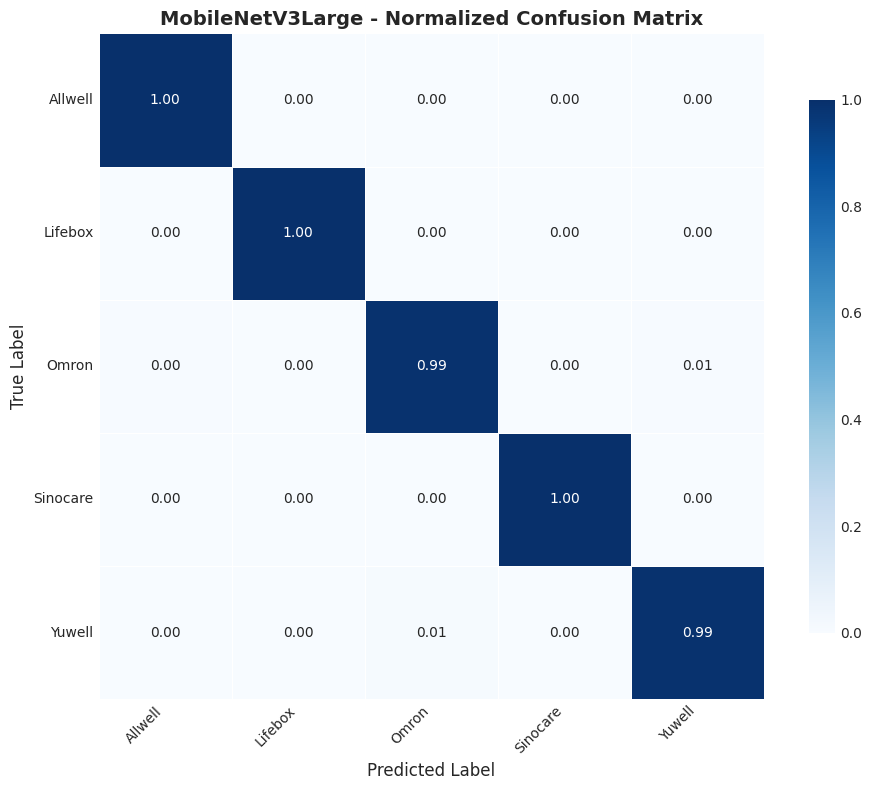

2026-02-04 18:18:37.933063: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 18:18:38.044231: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-04 18:18:40.271302: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report for MobileNetV3Large (Test):
              precision    recall  f1-score   support

     Allwell     1.0000    1.0000    1.0000        13
     Lifebox     1.0000    1.0000    1.0000         7
       Omron     1.0000    1.0000    1.0000        44
    Sinocare     1.0000    1.0000    1.0000        19
      Yuwell     1.0000    1.0000    1.0000        17

    accuracy                         1.0000       100
   macro avg     1.0000    1.0000    1.0000       100
weighted avg     1.0000    1.0000    1.0000       100

Reports saved to: results/MobileNetV3Large/reports


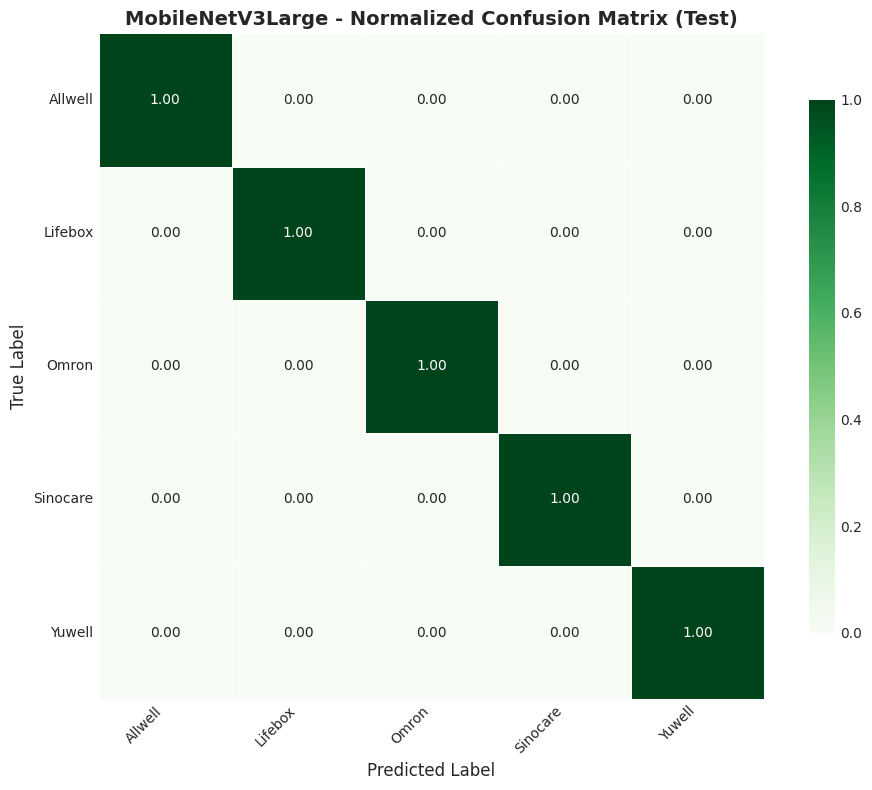


Computing metrics for DenseNet121

Classification Report for DenseNet121 (Validation):
              precision    recall  f1-score   support

     Allwell     1.0000    0.9921    0.9960       127
     Lifebox     1.0000    1.0000    1.0000        75
       Omron     0.9960    0.9900    0.9930       502
    Sinocare     0.9949    1.0000    0.9975       196
      Yuwell     0.9752    0.9899    0.9825       199

    accuracy                         0.9927      1099
   macro avg     0.9932    0.9944    0.9938      1099
weighted avg     0.9928    0.9927    0.9927      1099

Reports saved to: results/DenseNet121/reports


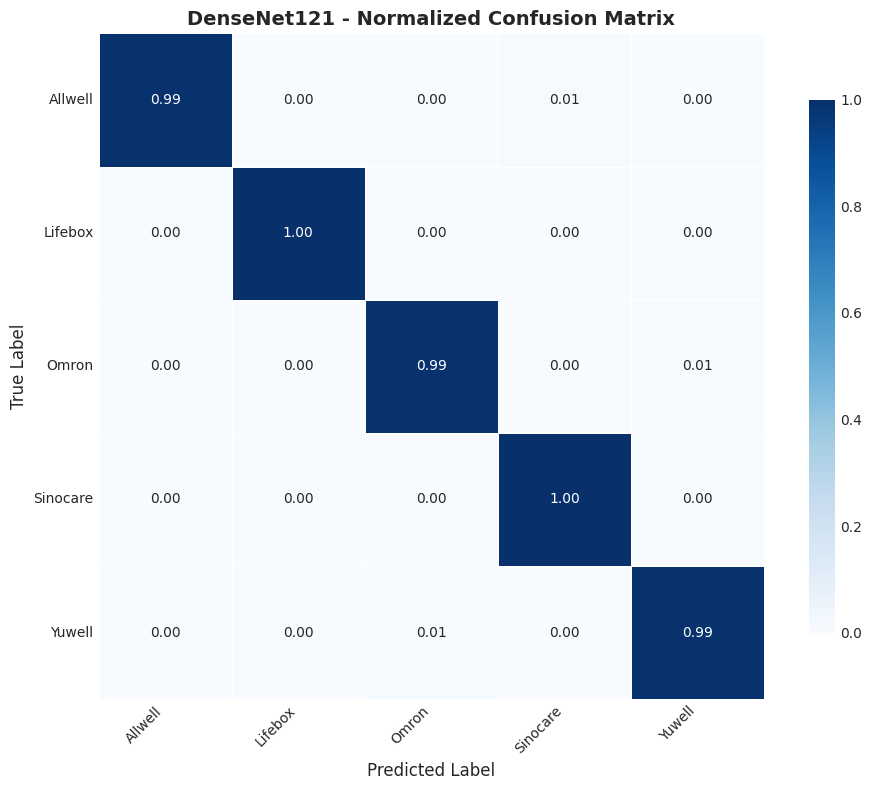

Classification Report for DenseNet121 (Test):
              precision    recall  f1-score   support

     Allwell     1.0000    1.0000    1.0000        13
     Lifebox     1.0000    1.0000    1.0000         7
       Omron     1.0000    1.0000    1.0000        44
    Sinocare     1.0000    1.0000    1.0000        19
      Yuwell     1.0000    1.0000    1.0000        17

    accuracy                         1.0000       100
   macro avg     1.0000    1.0000    1.0000       100
weighted avg     1.0000    1.0000    1.0000       100

Reports saved to: results/DenseNet121/reports


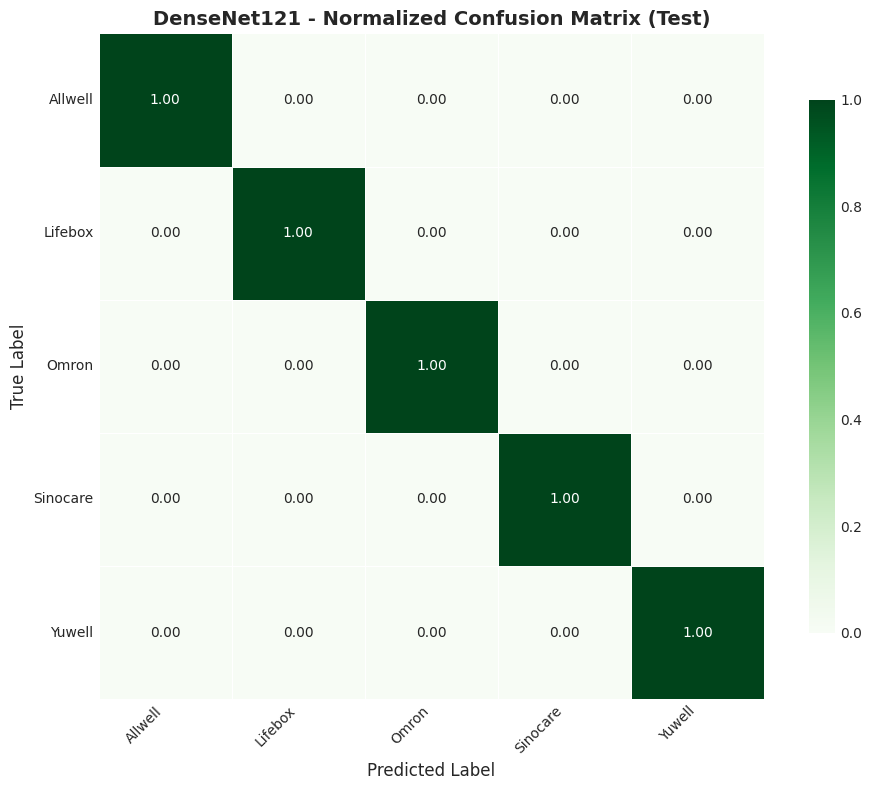


Computing metrics for ConvNeXtTiny

Classification Report for ConvNeXtTiny (Validation):
              precision    recall  f1-score   support

     Allwell     1.0000    1.0000    1.0000       127
     Lifebox     1.0000    1.0000    1.0000        75
       Omron     1.0000    1.0000    1.0000       502
    Sinocare     1.0000    1.0000    1.0000       196
      Yuwell     1.0000    1.0000    1.0000       199

    accuracy                         1.0000      1099
   macro avg     1.0000    1.0000    1.0000      1099
weighted avg     1.0000    1.0000    1.0000      1099

Reports saved to: results/ConvNeXtTiny/reports


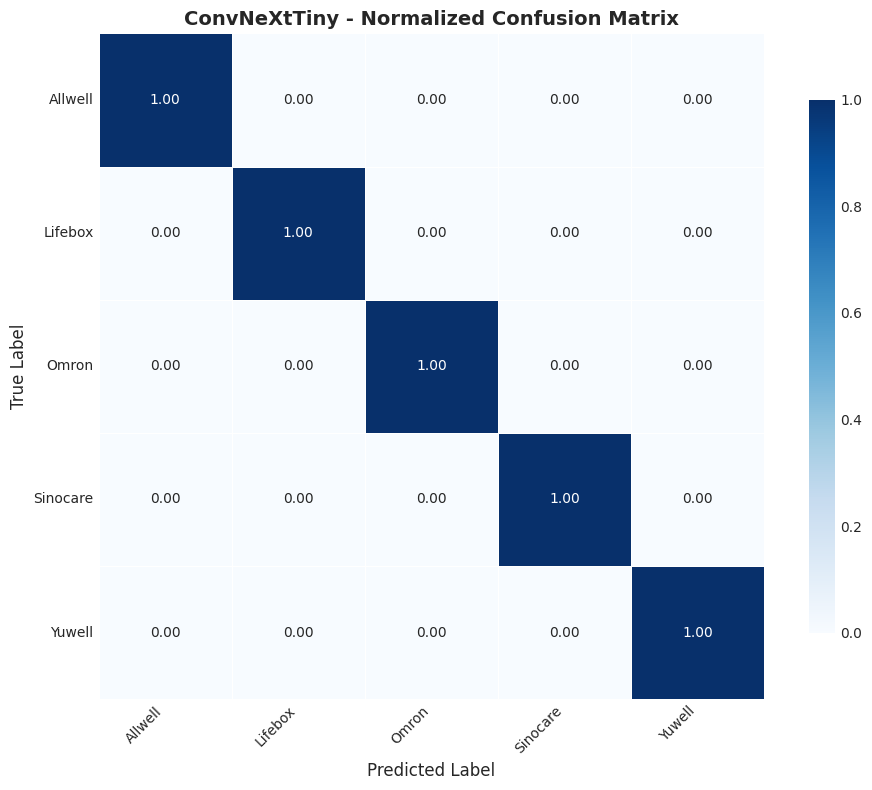

2026-02-04 18:19:36.382301: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 4 bytes spill stores, 4 bytes spill loads

2026-02-04 18:19:36.917182: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 4 bytes spill stores, 4 bytes spill loads

2026-02-04 18:19:36.989862: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 64 bytes spill stores, 64 bytes spill loads

2026-02-04 18:19:37.099007: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 16 bytes spill stores, 16 bytes spill loads

2026-02-04 18:19:37.143686: I external/local_xla/xla/

Classification Report for ConvNeXtTiny (Test):
              precision    recall  f1-score   support

     Allwell     1.0000    1.0000    1.0000        13
     Lifebox     1.0000    1.0000    1.0000         7
       Omron     1.0000    1.0000    1.0000        44
    Sinocare     1.0000    1.0000    1.0000        19
      Yuwell     1.0000    1.0000    1.0000        17

    accuracy                         1.0000       100
   macro avg     1.0000    1.0000    1.0000       100
weighted avg     1.0000    1.0000    1.0000       100

Reports saved to: results/ConvNeXtTiny/reports


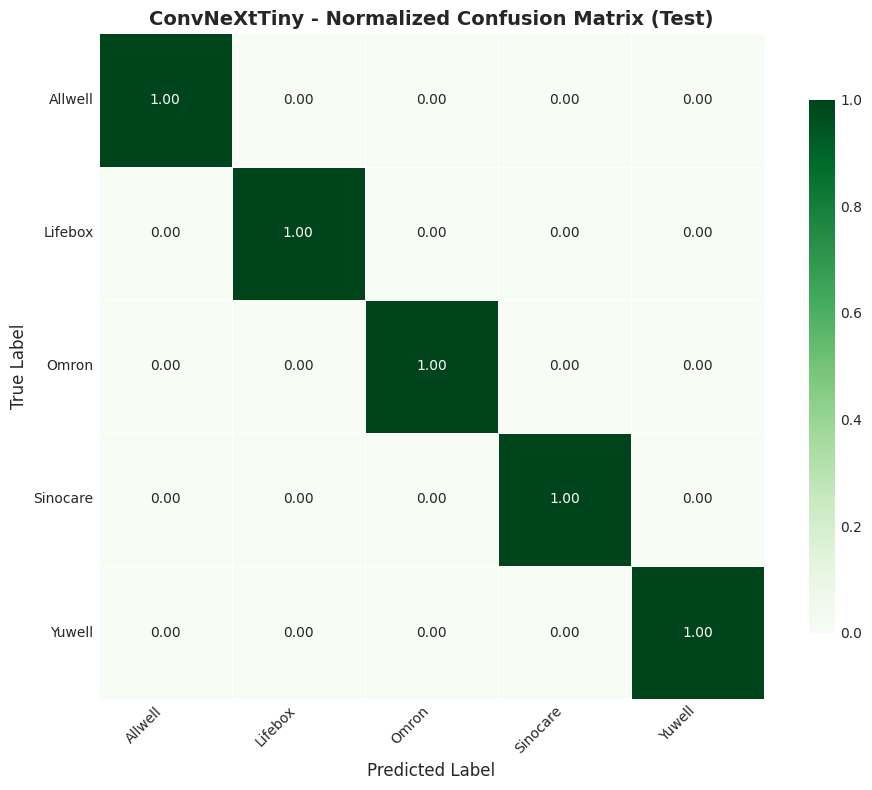


Computing metrics for NASNetMobile

Classification Report for NASNetMobile (Validation):
              precision    recall  f1-score   support

     Allwell     1.0000    0.9843    0.9921       127
     Lifebox     0.9487    0.9867    0.9673        75
       Omron     0.9880    0.9880    0.9880       502
    Sinocare     1.0000    0.9949    0.9974       196
      Yuwell     0.9648    0.9648    0.9648       199

    accuracy                         0.9845      1099
   macro avg     0.9803    0.9837    0.9819      1099
weighted avg     0.9847    0.9845    0.9846      1099

Reports saved to: results/NASNetMobile/reports


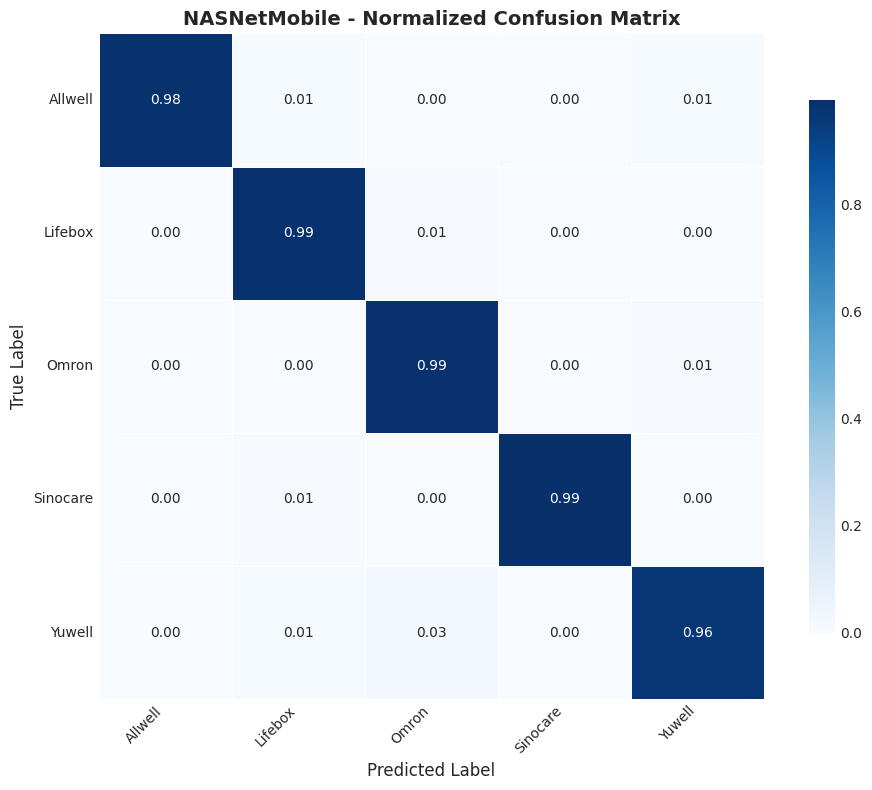

Classification Report for NASNetMobile (Test):
              precision    recall  f1-score   support

     Allwell     0.9286    1.0000    0.9630        13
     Lifebox     0.8750    1.0000    0.9333         7
       Omron     0.9778    1.0000    0.9888        44
    Sinocare     1.0000    1.0000    1.0000        19
      Yuwell     1.0000    0.8235    0.9032        17

    accuracy                         0.9700       100
   macro avg     0.9563    0.9647    0.9577       100
weighted avg     0.9722    0.9700    0.9691       100

Reports saved to: results/NASNetMobile/reports


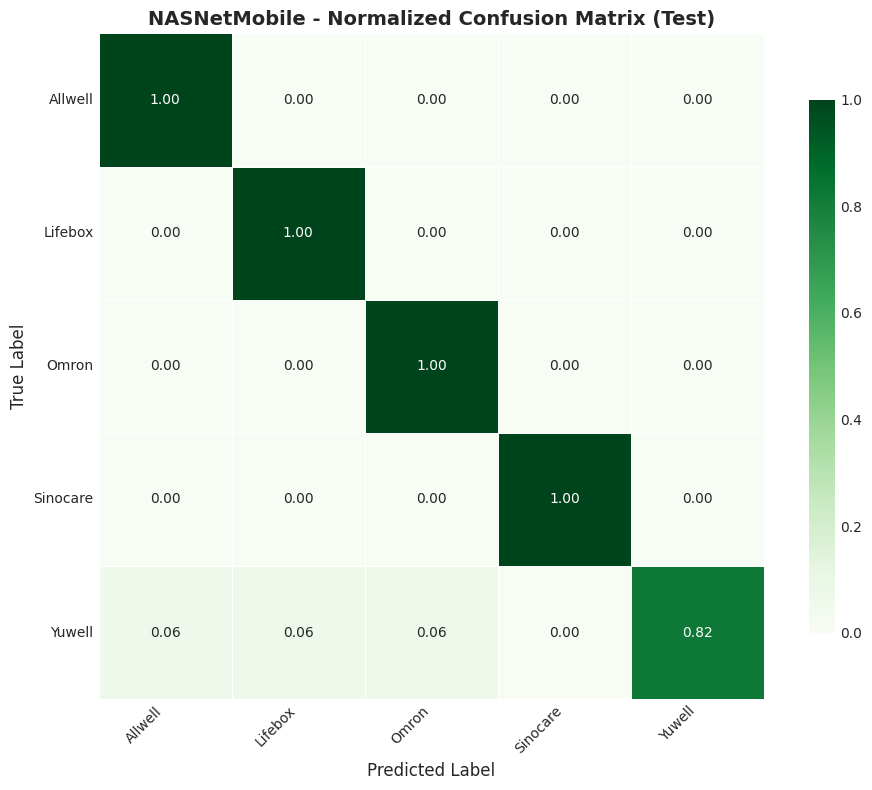

In [13]:
# Cell 14: Compute Metrics for All Models
# Store all models, datasets, and training times
models_dict = {
    "EfficientNetV2B0": (model_efficientnet, val_ds_efficientnet, test_ds_efficientnet, time_efficientnet),
    "MobileNetV3Large": (model_mobilenet, val_ds_mobilenet, test_ds_mobilenet, time_mobilenet),
    "DenseNet121": (model_densenet, val_ds_densenet, test_ds_densenet, time_densenet),
    "ConvNeXtTiny": (model_convnext, val_ds_convnext, test_ds_convnext, time_convnext),
    "NASNetMobile": (model_nasnet, val_ds_nasnet, test_ds_nasnet, time_nasnet),
}
model_names = list(models_dict.keys())

# Store all metrics
all_metrics = {}
all_predictions = {}
all_test_metrics = {}
all_test_predictions = {}

for model_name, (model, val_ds, test_ds, train_time) in models_dict.items():
    print(f"\n{'='*60}")
    print(f"Computing metrics for {model_name}")
    print(f"{'='*60}")
    
    # Get validation predictions
    y_true_val, y_pred_val = get_predictions(model, val_ds)
    all_predictions[model_name] = (y_true_val, y_pred_val)
    
    # Compute validation metrics
    metrics = compute_metrics(y_true_val, y_pred_val, class_names)
    metrics["training_time_seconds"] = train_time
    metrics["training_time_minutes"] = train_time / 60
    all_metrics[model_name] = metrics
    
    print(f"\nClassification Report for {model_name} (Validation):")
    print(classification_report(y_true_val, y_pred_val, target_names=class_names, digits=4))
    
    # Save validation metrics report for this model
    save_model_metrics_report(model_name, metrics, class_names, prefix="valid")
    
    # Plot and save confusion matrix for this model
    plot_confusion_matrix(y_true_val, y_pred_val, class_names, model_name, normalize=True)
    
    # Compute test metrics if available
    if test_ds is not None:
        y_true_test, y_pred_test = get_predictions(model, test_ds)
        all_test_predictions[model_name] = (y_true_test, y_pred_test)
        test_metrics = compute_metrics(y_true_test, y_pred_test, class_names)
        all_test_metrics[model_name] = test_metrics
        
        for key, value in test_metrics.items():
            metrics[f"test_{key}"] = value
        
        print(f"Classification Report for {model_name} (Test):")
        print(classification_report(y_true_test, y_pred_test, target_names=class_names, digits=4))
        
        # Save test metrics report for this model
        save_model_metrics_report(model_name, test_metrics, class_names, prefix="test")
        
        # Plot and save test confusion matrix
        figures_dir = get_figures_dir(model_name)
        cm_test = confusion_matrix(y_true_test, y_pred_test)
        cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_test_norm, annot=True, fmt='.2f', cmap='Greens',
                    xticklabels=class_names, yticklabels=class_names,
                    square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
        plt.title(f'{model_name} - Normalized Confusion Matrix (Test)', fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(figures_dir / f"test_{model_name}_confusion_matrix_normalized.png", dpi=150, bbox_inches='tight')
        plt.show()
    else:
        all_test_metrics[model_name] = None
        print("No test dataset available for this model.")

### Normalized Confusion Matrices for Each Model

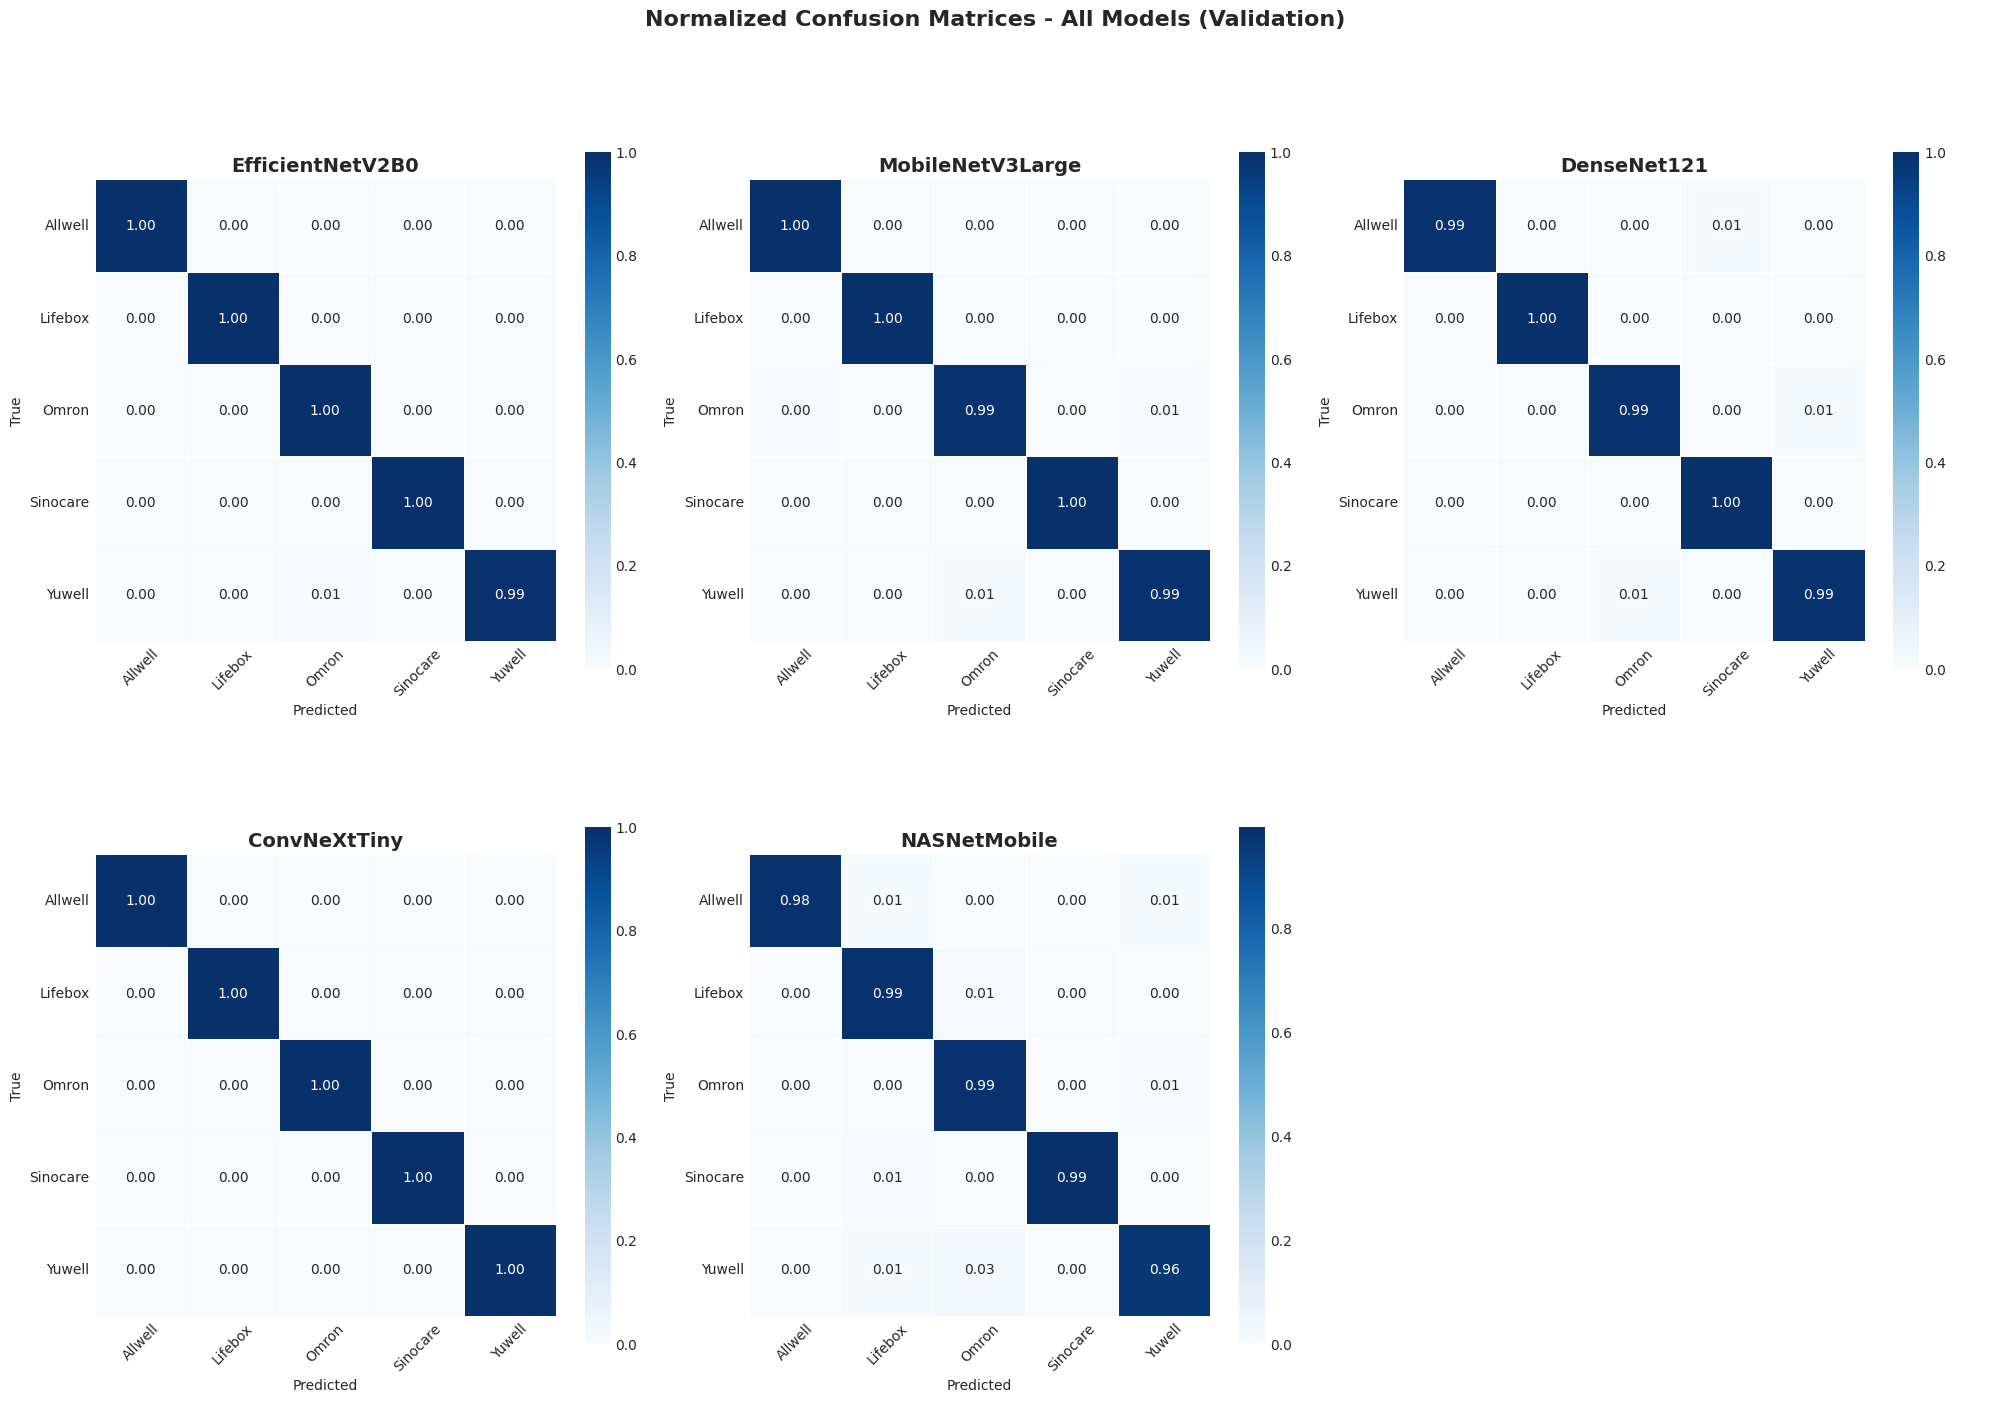

Saved to: results/_comparison


In [14]:
# Cell 15: Plot Normalized Confusion Matrices for All Models (Validation) - Comparison
comparison_dir = get_comparison_dir()

fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

model_names = list(all_predictions.keys())

for idx, model_name in enumerate(model_names):
    y_true, y_pred = all_predictions[model_name]
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                square=True, linewidths=0.5, ax=axes[idx],
                cbar_kws={"shrink": 0.8})
    axes[idx].set_title(f'{model_name}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('True', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].tick_params(axis='y', rotation=0)

# Hide the 6th subplot if we only have 5 models
if len(model_names) < 6:
    axes[5].axis('off')

plt.suptitle('Normalized Confusion Matrices - All Models (Validation)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(comparison_dir / "valid_all_confusion_matrices_normalized.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved to: {comparison_dir}")

### Performance Metrics Comparison (Precision, Recall, F1-Score, Accuracy)

Validation Performance Metrics Comparison:
                  Accuracy  Precision (Macro)  Recall (Macro)  F1-Score (Macro)  Precision (Weighted)  Recall (Weighted)  F1-Score (Weighted)
Model                                                                                                                                        
EfficientNetV2B0  0.998180           0.998597        0.998597          0.998597              0.998180           0.998180             0.998180
MobileNetV3Large  0.993631           0.993098        0.995998          0.994533              0.993661           0.993631             0.993634
DenseNet121       0.992721           0.993233        0.994423          0.993811              0.992782           0.992721             0.992734
ConvNeXtTiny      1.000000           1.000000        1.000000          1.000000              1.000000           1.000000             1.000000
NASNetMobile      0.984531           0.980318        0.983738          0.981940              0.984671    

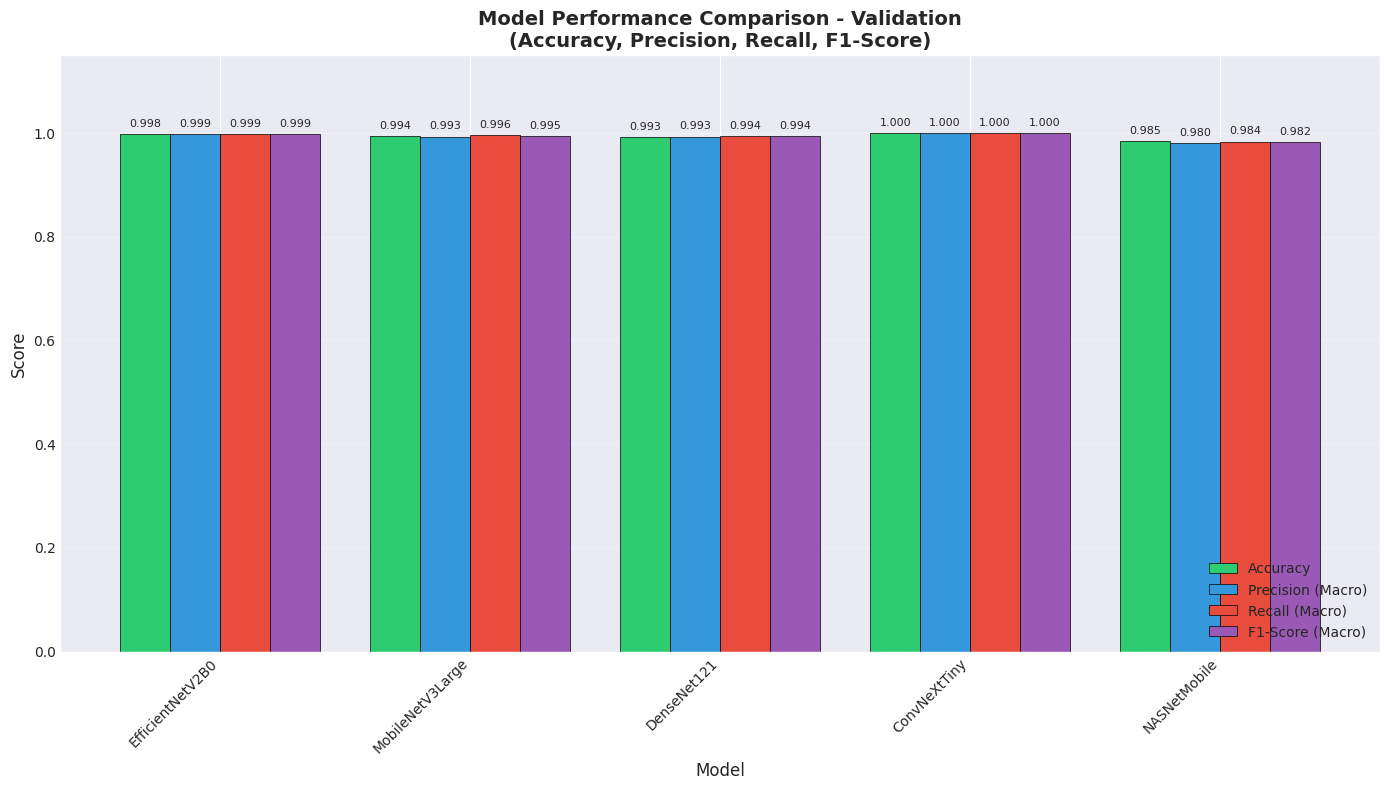

Saved to: results/_comparison


In [15]:
# Cell 16: Compare Performance Metrics (Precision, Recall, F1, Accuracy) - Validation
comparison_dir = get_comparison_dir()

# Create DataFrame for main metrics
metrics_data = []
for model_name, metrics in all_metrics.items():
    metrics_data.append({
        "Model": model_name,
        "Accuracy": metrics["accuracy"],
        "Precision (Macro)": metrics["precision_macro"],
        "Recall (Macro)": metrics["recall_macro"],
        "F1-Score (Macro)": metrics["f1_macro"],
        "Precision (Weighted)": metrics["precision_weighted"],
        "Recall (Weighted)": metrics["recall_weighted"],
        "F1-Score (Weighted)": metrics["f1_weighted"],
    })

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.set_index("Model")
print("Validation Performance Metrics Comparison:")
print(metrics_df.to_string())

# Save comparison CSV
metrics_df.to_csv(comparison_dir / "valid_all_models_metrics_comparison.csv")

# Plot grouped bar chart for main metrics
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(model_names))
width = 0.2

metrics_to_plot = ["Accuracy", "Precision (Macro)", "Recall (Macro)", "F1-Score (Macro)"]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    values = [metrics_df.loc[model, metric] for model in model_names]
    bars = ax.bar(x + i * width, values, width, label=metric, color=color, edgecolor='black', linewidth=0.5)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=8, rotation=0)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison - Validation\n(Accuracy, Precision, Recall, F1-Score)', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend(loc='lower right', fontsize=10)
ax.set_ylim([0, 1.15])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(comparison_dir / "valid_performance_metrics_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved to: {comparison_dir}")

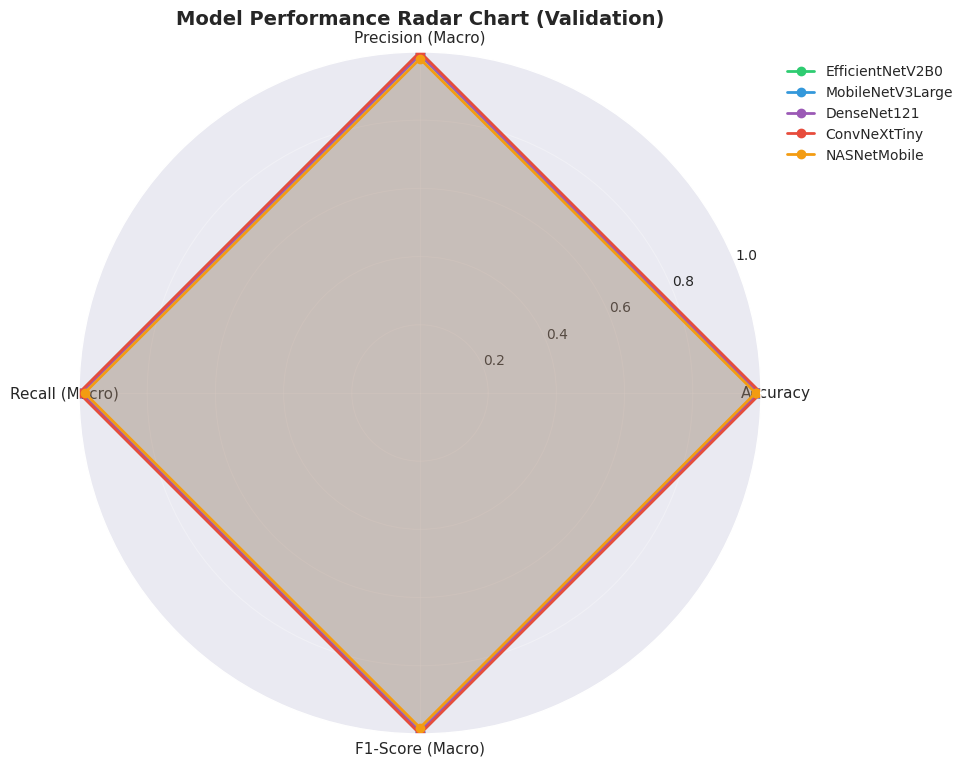

Saved to: results/_comparison


In [16]:
# Cell 17: Radar Chart for Multi-Metric Comparison (Validation)
def plot_radar_chart(metrics_df, model_names, title_suffix="Validation", save_path=None):
    """Create a radar chart comparing models across metrics."""
    categories = ["Accuracy", "Precision (Macro)", "Recall (Macro)", "F1-Score (Macro)"]
    N = len(categories)
    
    # Create angles for radar chart
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the loop
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']
    
    for idx, model in enumerate(model_names):
        values = [metrics_df.loc[model, cat] for cat in categories]
        values += values[:1]  # Complete the loop
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[idx])
        ax.fill(angles, values, alpha=0.1, color=colors[idx])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)
    ax.set_ylim(0, 1)
    ax.set_title(f'Model Performance Radar Chart ({title_suffix})', fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

comparison_dir = get_comparison_dir()
plot_radar_chart(metrics_df, model_names, title_suffix="Validation", 
                 save_path=comparison_dir / "valid_radar_chart_comparison.png")
print(f"Saved to: {comparison_dir}")

Test Performance Metrics Comparison:
                  Test Accuracy  Test Precision (Macro)  Test Recall (Macro)  Test F1-Score (Macro)  Test Precision (Weighted)  Test Recall (Weighted)  Test F1-Score (Weighted)
Model                                                                                                                                                                           
EfficientNetV2B0           1.00                 1.00000             1.000000               1.000000                   1.000000                    1.00                  1.000000
MobileNetV3Large           1.00                 1.00000             1.000000               1.000000                   1.000000                    1.00                  1.000000
DenseNet121                1.00                 1.00000             1.000000               1.000000                   1.000000                    1.00                  1.000000
ConvNeXtTiny               1.00                 1.00000             1.000000  

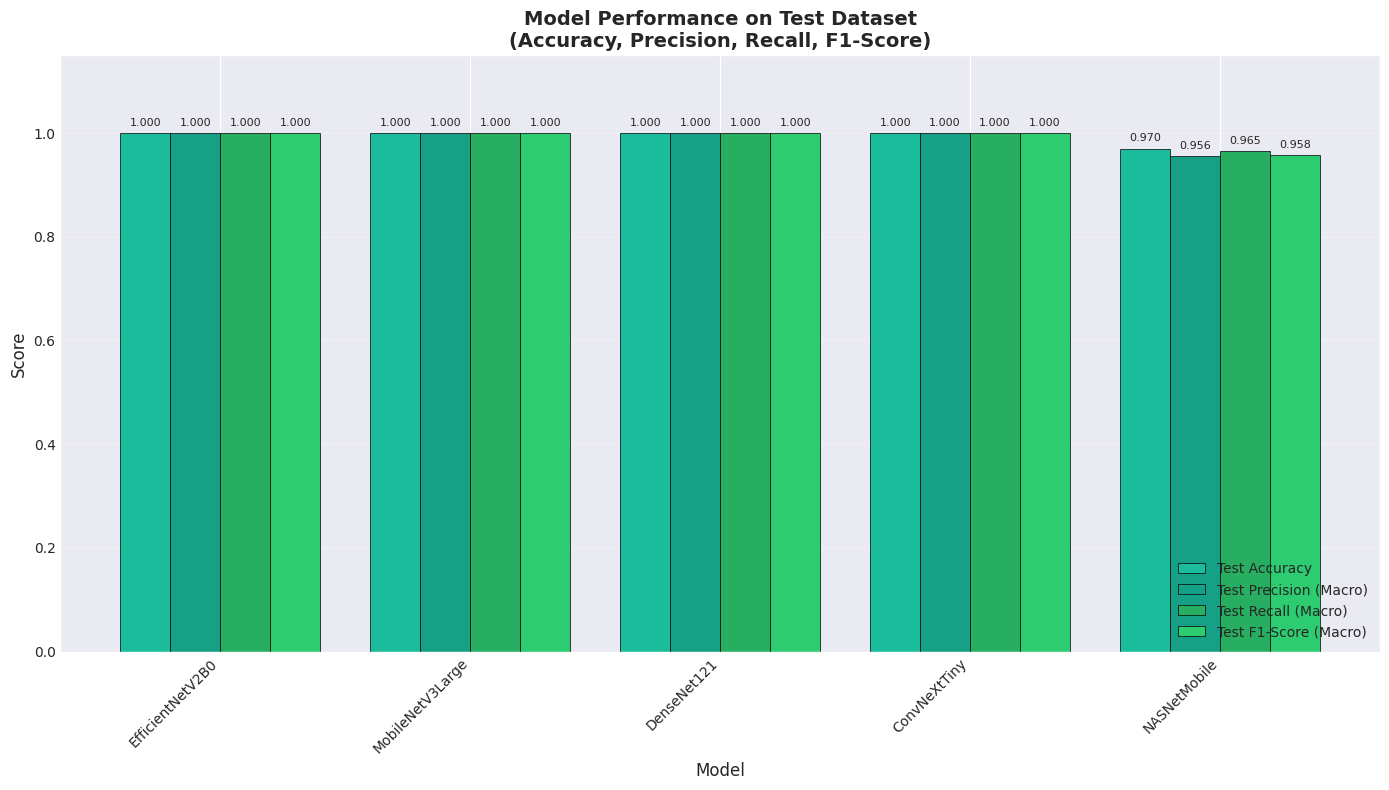

Saved to: results/_comparison


In [17]:
# Cell 16b: Test Performance Metrics (if available)
comparison_dir = get_comparison_dir()

if any("test_accuracy" in all_metrics[m] for m in model_names):
    test_metrics_data = []
    for model_name in model_names:
        metrics = all_metrics[model_name]
        if "test_accuracy" in metrics:
            test_metrics_data.append({
                "Model": model_name,
                "Test Accuracy": metrics["test_accuracy"],
                "Test Precision (Macro)": metrics["test_precision_macro"],
                "Test Recall (Macro)": metrics["test_recall_macro"],
                "Test F1-Score (Macro)": metrics["test_f1_macro"],
                "Test Precision (Weighted)": metrics["test_precision_weighted"],
                "Test Recall (Weighted)": metrics["test_recall_weighted"],
                "Test F1-Score (Weighted)": metrics["test_f1_weighted"],
            })
    if test_metrics_data:
        test_metrics_df = pd.DataFrame(test_metrics_data).set_index("Model")
        print("Test Performance Metrics Comparison:")
        print(test_metrics_df.to_string())
        
        # Save comparison CSV
        test_metrics_df.to_csv(comparison_dir / "test_all_models_metrics_comparison.csv")
        
        fig, ax = plt.subplots(figsize=(14, 8))
        x = np.arange(len(test_metrics_df))
        width = 0.2
        metrics_to_plot = ["Test Accuracy", "Test Precision (Macro)", "Test Recall (Macro)", "Test F1-Score (Macro)"]
        colors = ['#1abc9c', '#16a085', '#27ae60', '#2ecc71']
        for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
            values = test_metrics_df[metric].values
            bars = ax.bar(x + i * width, values, width, label=metric, color=color, edgecolor='black', linewidth=0.5)
            for bar, val in zip(bars, values):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=8)
        ax.set_xlabel('Model', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Model Performance on Test Dataset\n(Accuracy, Precision, Recall, F1-Score)', fontsize=14, fontweight='bold')
        ax.set_xticks(x + width * 1.5)
        ax.set_xticklabels(test_metrics_df.index, rotation=45, ha='right')
        ax.legend(loc='lower right', fontsize=10)
        ax.set_ylim([0, 1.15])
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig(comparison_dir / "test_performance_metrics_comparison.png", dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved to: {comparison_dir}")
else:
    print("No test dataset metrics available.")

### Test Dataset Evaluation - Comprehensive Results

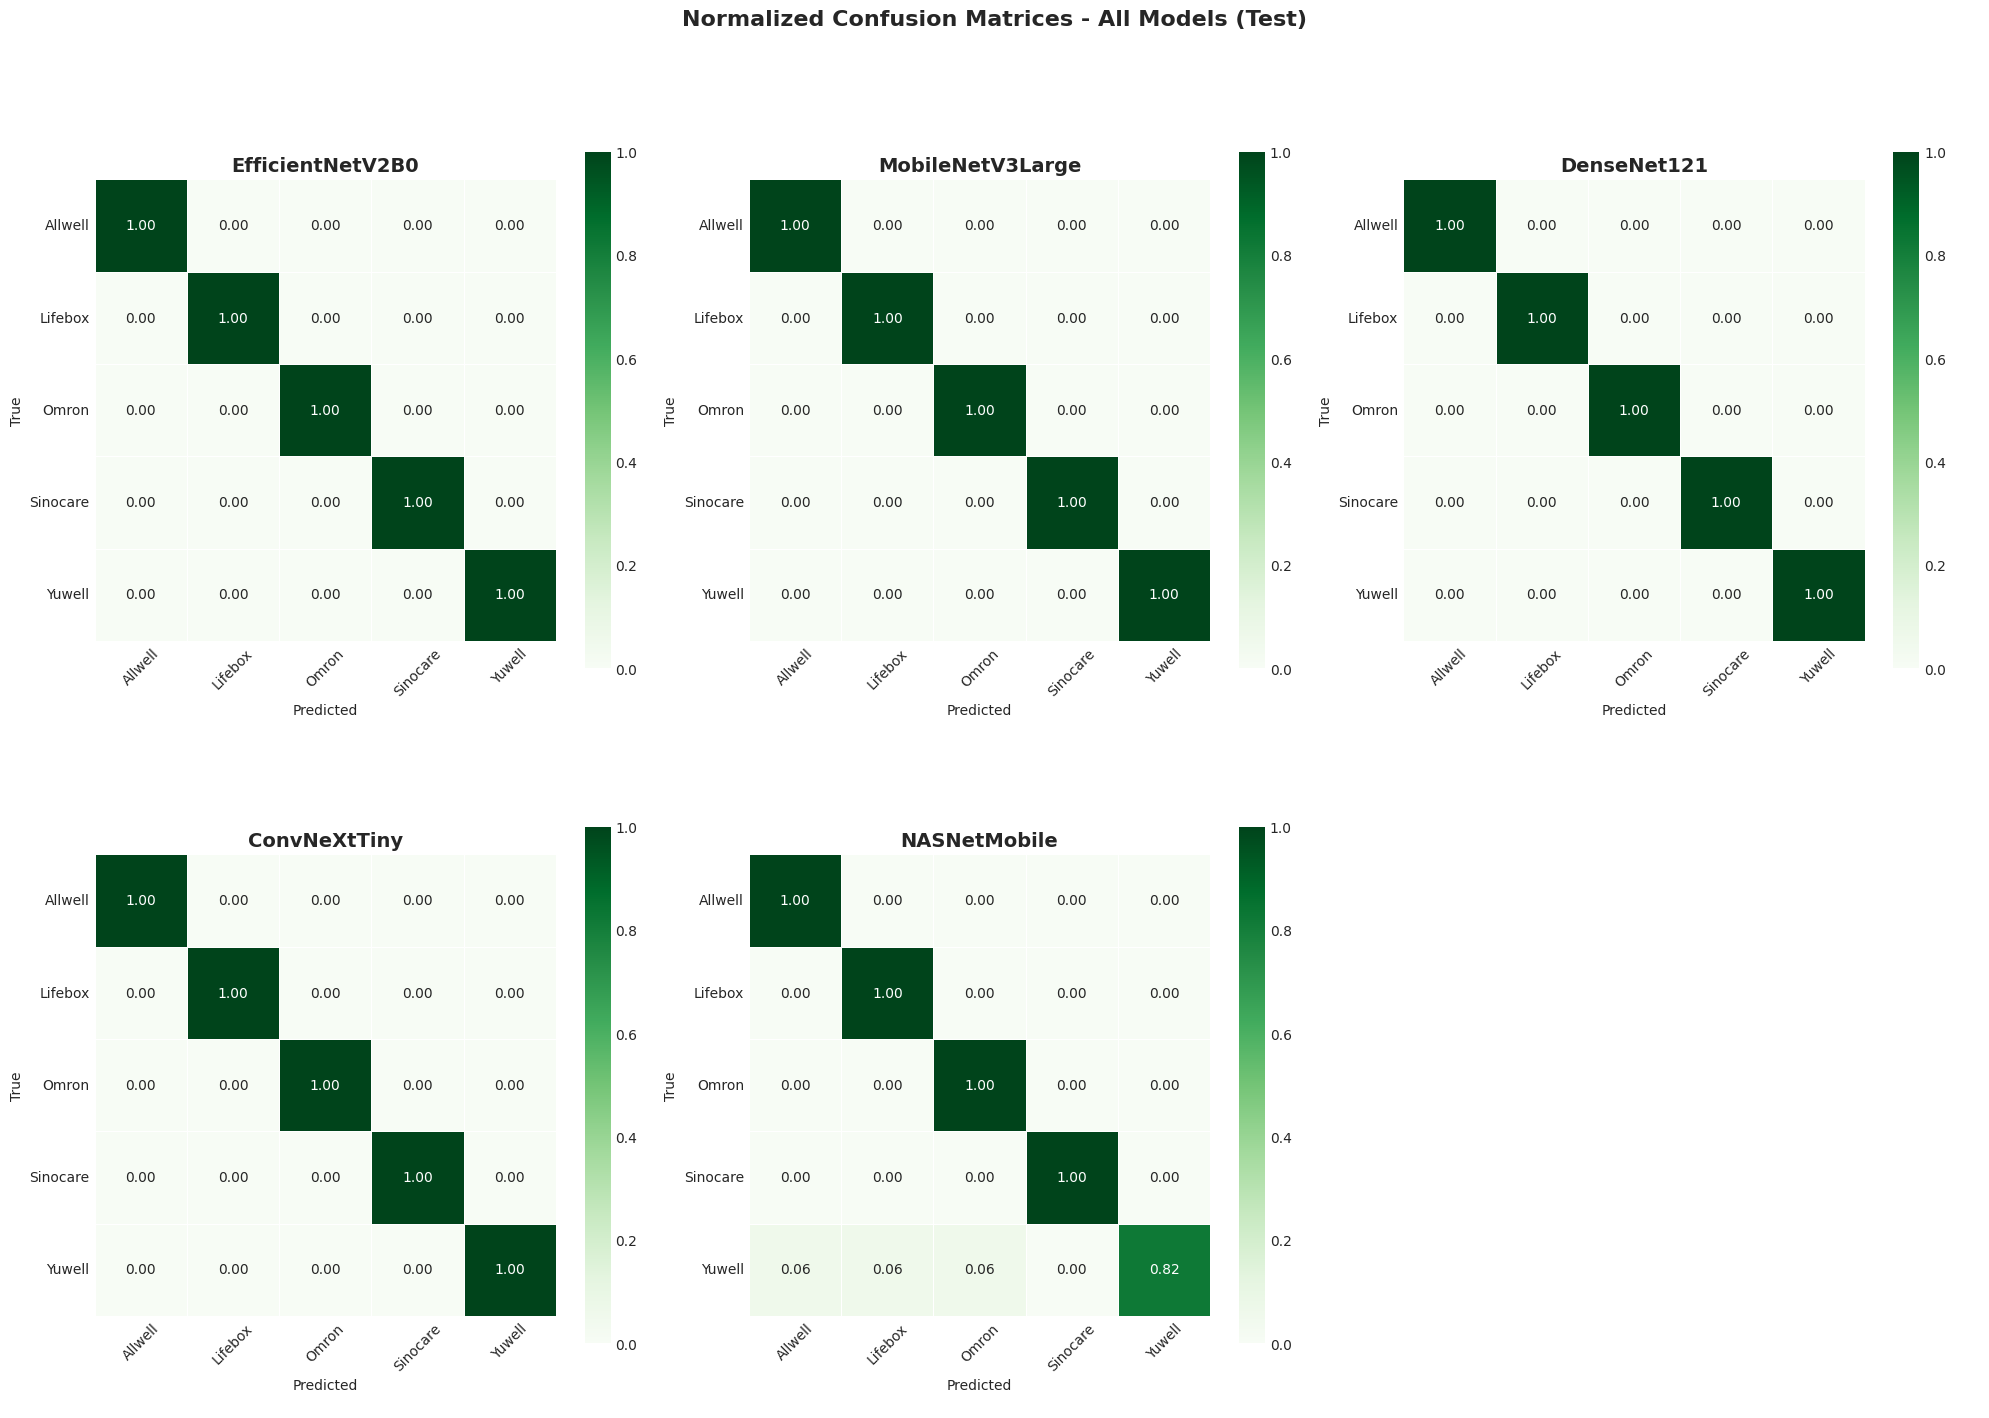

Saved to: results/_comparison


In [18]:
# Cell: Test Confusion Matrices for All Models (Comparison)
comparison_dir = get_comparison_dir()

if any("test_accuracy" in all_metrics[m] for m in model_names):
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    axes = axes.flatten()
    
    for idx, model_name in enumerate(model_names):
        if model_name in all_test_predictions:
            y_true, y_pred = all_test_predictions[model_name]
            cm = confusion_matrix(y_true, y_pred)
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            
            sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens',
                        xticklabels=class_names, yticklabels=class_names,
                        square=True, linewidths=0.5, ax=axes[idx],
                        cbar_kws={"shrink": 0.8})
            axes[idx].set_title(f'{model_name}', fontsize=14, fontweight='bold')
            axes[idx].set_xlabel('Predicted', fontsize=10)
            axes[idx].set_ylabel('True', fontsize=10)
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].tick_params(axis='y', rotation=0)
        else:
            axes[idx].axis('off')
    
    if len(model_names) < 6:
        axes[5].axis('off')
    
    plt.suptitle('Normalized Confusion Matrices - All Models (Test)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(comparison_dir / "test_all_confusion_matrices_normalized.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved to: {comparison_dir}")
else:
    print("No test predictions available for confusion matrix.")

TEST DATASET METRICS COMPARISON
                  Accuracy  Precision (Macro)  Recall (Macro)  F1-Score (Macro)  Precision (Weighted)  Recall (Weighted)  F1-Score (Weighted)
Model                                                                                                                                        
EfficientNetV2B0      1.00            1.00000        1.000000          1.000000              1.000000               1.00             1.000000
MobileNetV3Large      1.00            1.00000        1.000000          1.000000              1.000000               1.00             1.000000
DenseNet121           1.00            1.00000        1.000000          1.000000              1.000000               1.00             1.000000
ConvNeXtTiny          1.00            1.00000        1.000000          1.000000              1.000000               1.00             1.000000
NASNetMobile          0.97            0.95627        0.964706          0.957657              0.972187               

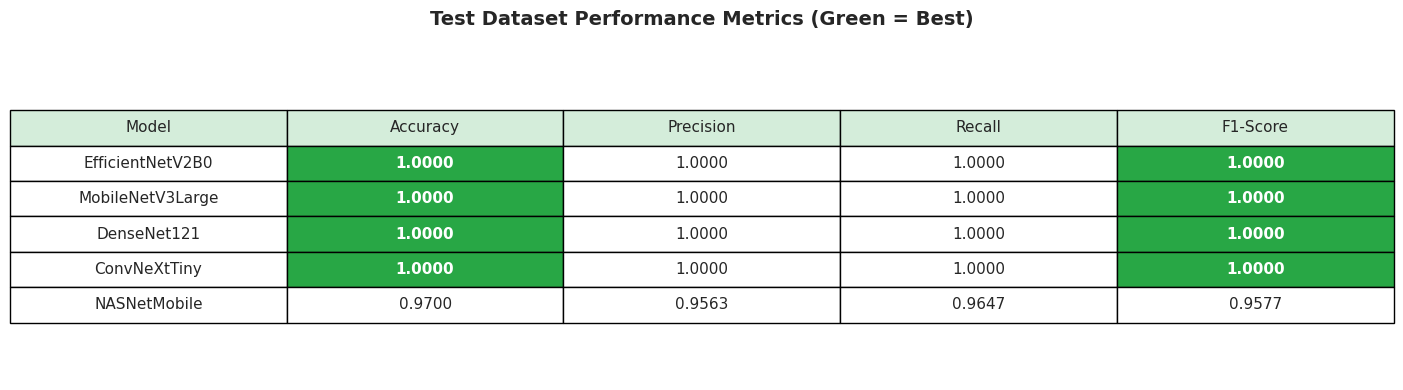

In [19]:
# Cell: Test Performance Metrics Table (Precision, Recall, F1, Accuracy)
comparison_dir = get_comparison_dir()

if any("test_accuracy" in all_metrics[m] for m in model_names):
    # Build comprehensive test metrics table
    test_table_data = []
    for model_name in model_names:
        metrics = all_metrics[model_name]
        if "test_accuracy" in metrics:
            test_table_data.append({
                "Model": model_name,
                "Accuracy": metrics["test_accuracy"],
                "Precision (Macro)": metrics["test_precision_macro"],
                "Recall (Macro)": metrics["test_recall_macro"],
                "F1-Score (Macro)": metrics["test_f1_macro"],
                "Precision (Weighted)": metrics["test_precision_weighted"],
                "Recall (Weighted)": metrics["test_recall_weighted"],
                "F1-Score (Weighted)": metrics["test_f1_weighted"],
            })
    
    test_table_df = pd.DataFrame(test_table_data).set_index("Model")
    
    print("=" * 80)
    print("TEST DATASET METRICS COMPARISON")
    print("=" * 80)
    print(test_table_df.to_string())
    print("=" * 80)
    
    # Save to CSV
    test_table_df.to_csv(comparison_dir / "test_metrics_comparison.csv")
    print(f"\nSaved to {comparison_dir / 'test_metrics_comparison.csv'}")
    
    # Plot as styled table
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.axis('off')
    
    cell_text = []
    for model in test_table_df.index:
        cell_text.append([
            model,
            f"{test_table_df.loc[model, 'Accuracy']:.4f}",
            f"{test_table_df.loc[model, 'Precision (Macro)']:.4f}",
            f"{test_table_df.loc[model, 'Recall (Macro)']:.4f}",
            f"{test_table_df.loc[model, 'F1-Score (Macro)']:.4f}",
        ])
    
    table = ax.table(
        cellText=cell_text,
        colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
        loc='center',
        cellLoc='center',
        colColours=['#d4edda'] * 5
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2.0)
    
    # Highlight best values
    acc_vals = [test_table_df.loc[m, 'Accuracy'] for m in test_table_df.index]
    f1_vals = [test_table_df.loc[m, 'F1-Score (Macro)'] for m in test_table_df.index]
    for i, model in enumerate(test_table_df.index):
        if test_table_df.loc[model, 'Accuracy'] == max(acc_vals):
            table[(i+1, 1)].set_facecolor('#28a745')
            table[(i+1, 1)].set_text_props(color='white', fontweight='bold')
        if test_table_df.loc[model, 'F1-Score (Macro)'] == max(f1_vals):
            table[(i+1, 4)].set_facecolor('#28a745')
            table[(i+1, 4)].set_text_props(color='white', fontweight='bold')
    
    ax.set_title('Test Dataset Performance Metrics (Green = Best)', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(comparison_dir / "test_metrics_table.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No test metrics available.")

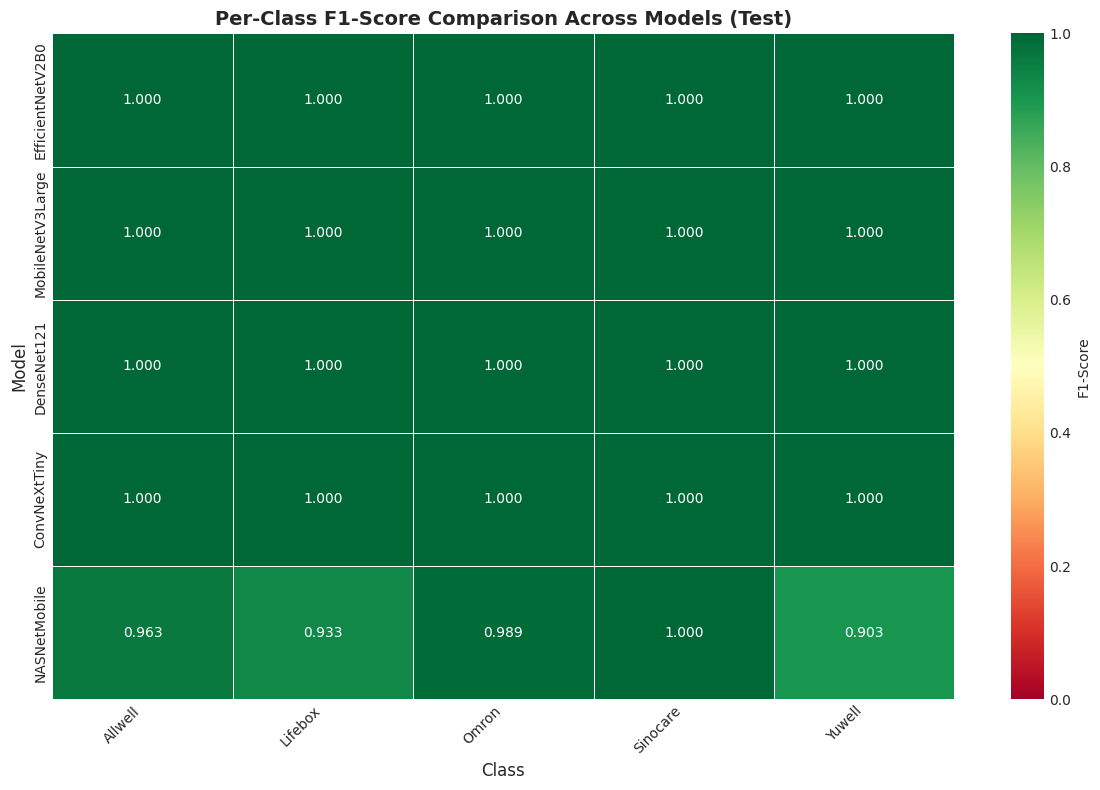


Per-Class F1-Score (Test):
                   Allwell   Lifebox     Omron  Sinocare    Yuwell
EfficientNetV2B0  1.000000  1.000000  1.000000       1.0  1.000000
MobileNetV3Large  1.000000  1.000000  1.000000       1.0  1.000000
DenseNet121       1.000000  1.000000  1.000000       1.0  1.000000
ConvNeXtTiny      1.000000  1.000000  1.000000       1.0  1.000000
NASNetMobile      0.962963  0.933333  0.988764       1.0  0.903226

Saved to: results/_comparison


In [20]:
# Cell: Test Per-Class F1-Score Heatmap
# Fallback if the configuration cell hasn't been run
try:
    get_comparison_dir
except NameError:
    try:
        Path
    except NameError:
        from pathlib import Path
    RESULTS_DIR = Path("./results")
    def get_comparison_dir() -> Path:
        path = RESULTS_DIR / "_comparison"
        path.mkdir(parents=True, exist_ok=True)
        return path
    print("Initialized get_comparison_dir with default RESULTS_DIR (config cell not run).")

comparison_dir = get_comparison_dir()

# Require aggregated metrics and class names
if 'model_names' not in globals() or 'all_metrics' not in globals() or 'class_names' not in globals():
    print("model_names/all_metrics/class_names not found. Run the metrics aggregation cell before this heatmap.")
else:
    if any("test_f1_macro" in all_metrics[m] for m in model_names):
        per_class_f1_test = []
        for model in model_names:
            f1_values = [all_metrics[model].get(f"test_f1_{cls}", 0.0) for cls in class_names]
            per_class_f1_test.append(f1_values)
        
        per_class_test_df = pd.DataFrame(per_class_f1_test, index=model_names, columns=class_names)
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(per_class_test_df, annot=True, fmt='.3f', cmap='RdYlGn', 
                    linewidths=0.5, vmin=0, vmax=1, cbar_kws={'label': 'F1-Score'})
        plt.title('Per-Class F1-Score Comparison Across Models (Test)', fontsize=14, fontweight='bold')
        plt.xlabel('Class', fontsize=12)
        plt.ylabel('Model', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(comparison_dir / "test_per_class_f1_heatmap.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        # Save CSV
        per_class_test_df.to_csv(comparison_dir / "test_per_class_f1_scores.csv")
        
        print("\nPer-Class F1-Score (Test):")
        print(per_class_test_df.to_string())
        print(f"\nSaved to: {comparison_dir}")
    else:
        print("No test per-class metrics available.")

In [21]:
# Cell: Helper function to get predictions with image data for visualization
def get_test_predictions_with_images(model, test_ds, preprocess_fn=None):
    """Get predictions along with images and labels for visualization."""
    all_images = []
    all_true_labels = []
    all_pred_labels = []
    all_confidences = []
    
    for images, labels in test_ds:
        # Store original images (before preprocessing for display)
        # Images are already preprocessed in test_ds, so we save them as-is
        batch_images = images.numpy()
        
        # Get predictions
        predictions = model.predict(images, verbose=0)
        pred_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(labels.numpy(), axis=1)
        confidences = np.max(predictions, axis=1)
        
        all_images.extend(batch_images)
        all_true_labels.extend(true_labels)
        all_pred_labels.extend(pred_labels)
        all_confidences.extend(confidences)
    
    return np.array(all_images), np.array(all_true_labels), np.array(all_pred_labels), np.array(all_confidences)

# Get images with predictions for visualization (using best model)
# We'll use the model with highest test accuracy
if any("test_accuracy" in all_metrics[m] for m in model_names):
    test_accs = {m: all_metrics[m].get("test_accuracy", 0) for m in model_names}
    best_model_name = max(test_accs, key=test_accs.get)
    print(f"Using best test model for visualization: {best_model_name} (Acc: {test_accs[best_model_name]:.4f})")
    
    best_model, _, test_ds, _ = models_dict[best_model_name]
    
    # Load test dataset without preprocessing for visualization
    config = MODEL_CONFIG[best_model_name]
    input_size = config["input_size"]
    preprocess_fn = config["preprocess"]
    
    test_ds_viz = image_dataset_from_directory(
        TEST_DIR,
        image_size=input_size,
        batch_size=BATCH_SIZE,
        shuffle=False,
        label_mode="categorical"
    )
    
    # Apply preprocessing for predictions but keep originals for display
    test_images_viz, test_true_viz, test_pred_viz, test_conf_viz = get_test_predictions_with_images(
        best_model, test_ds, preprocess_fn
    )
    
    print(f"Total test samples: {len(test_images_viz)}")
else:
    print("No test dataset available for visualization.")

Using best test model for visualization: EfficientNetV2B0 (Acc: 1.0000)
Found 100 files belonging to 5 classes.
Total test samples: 100


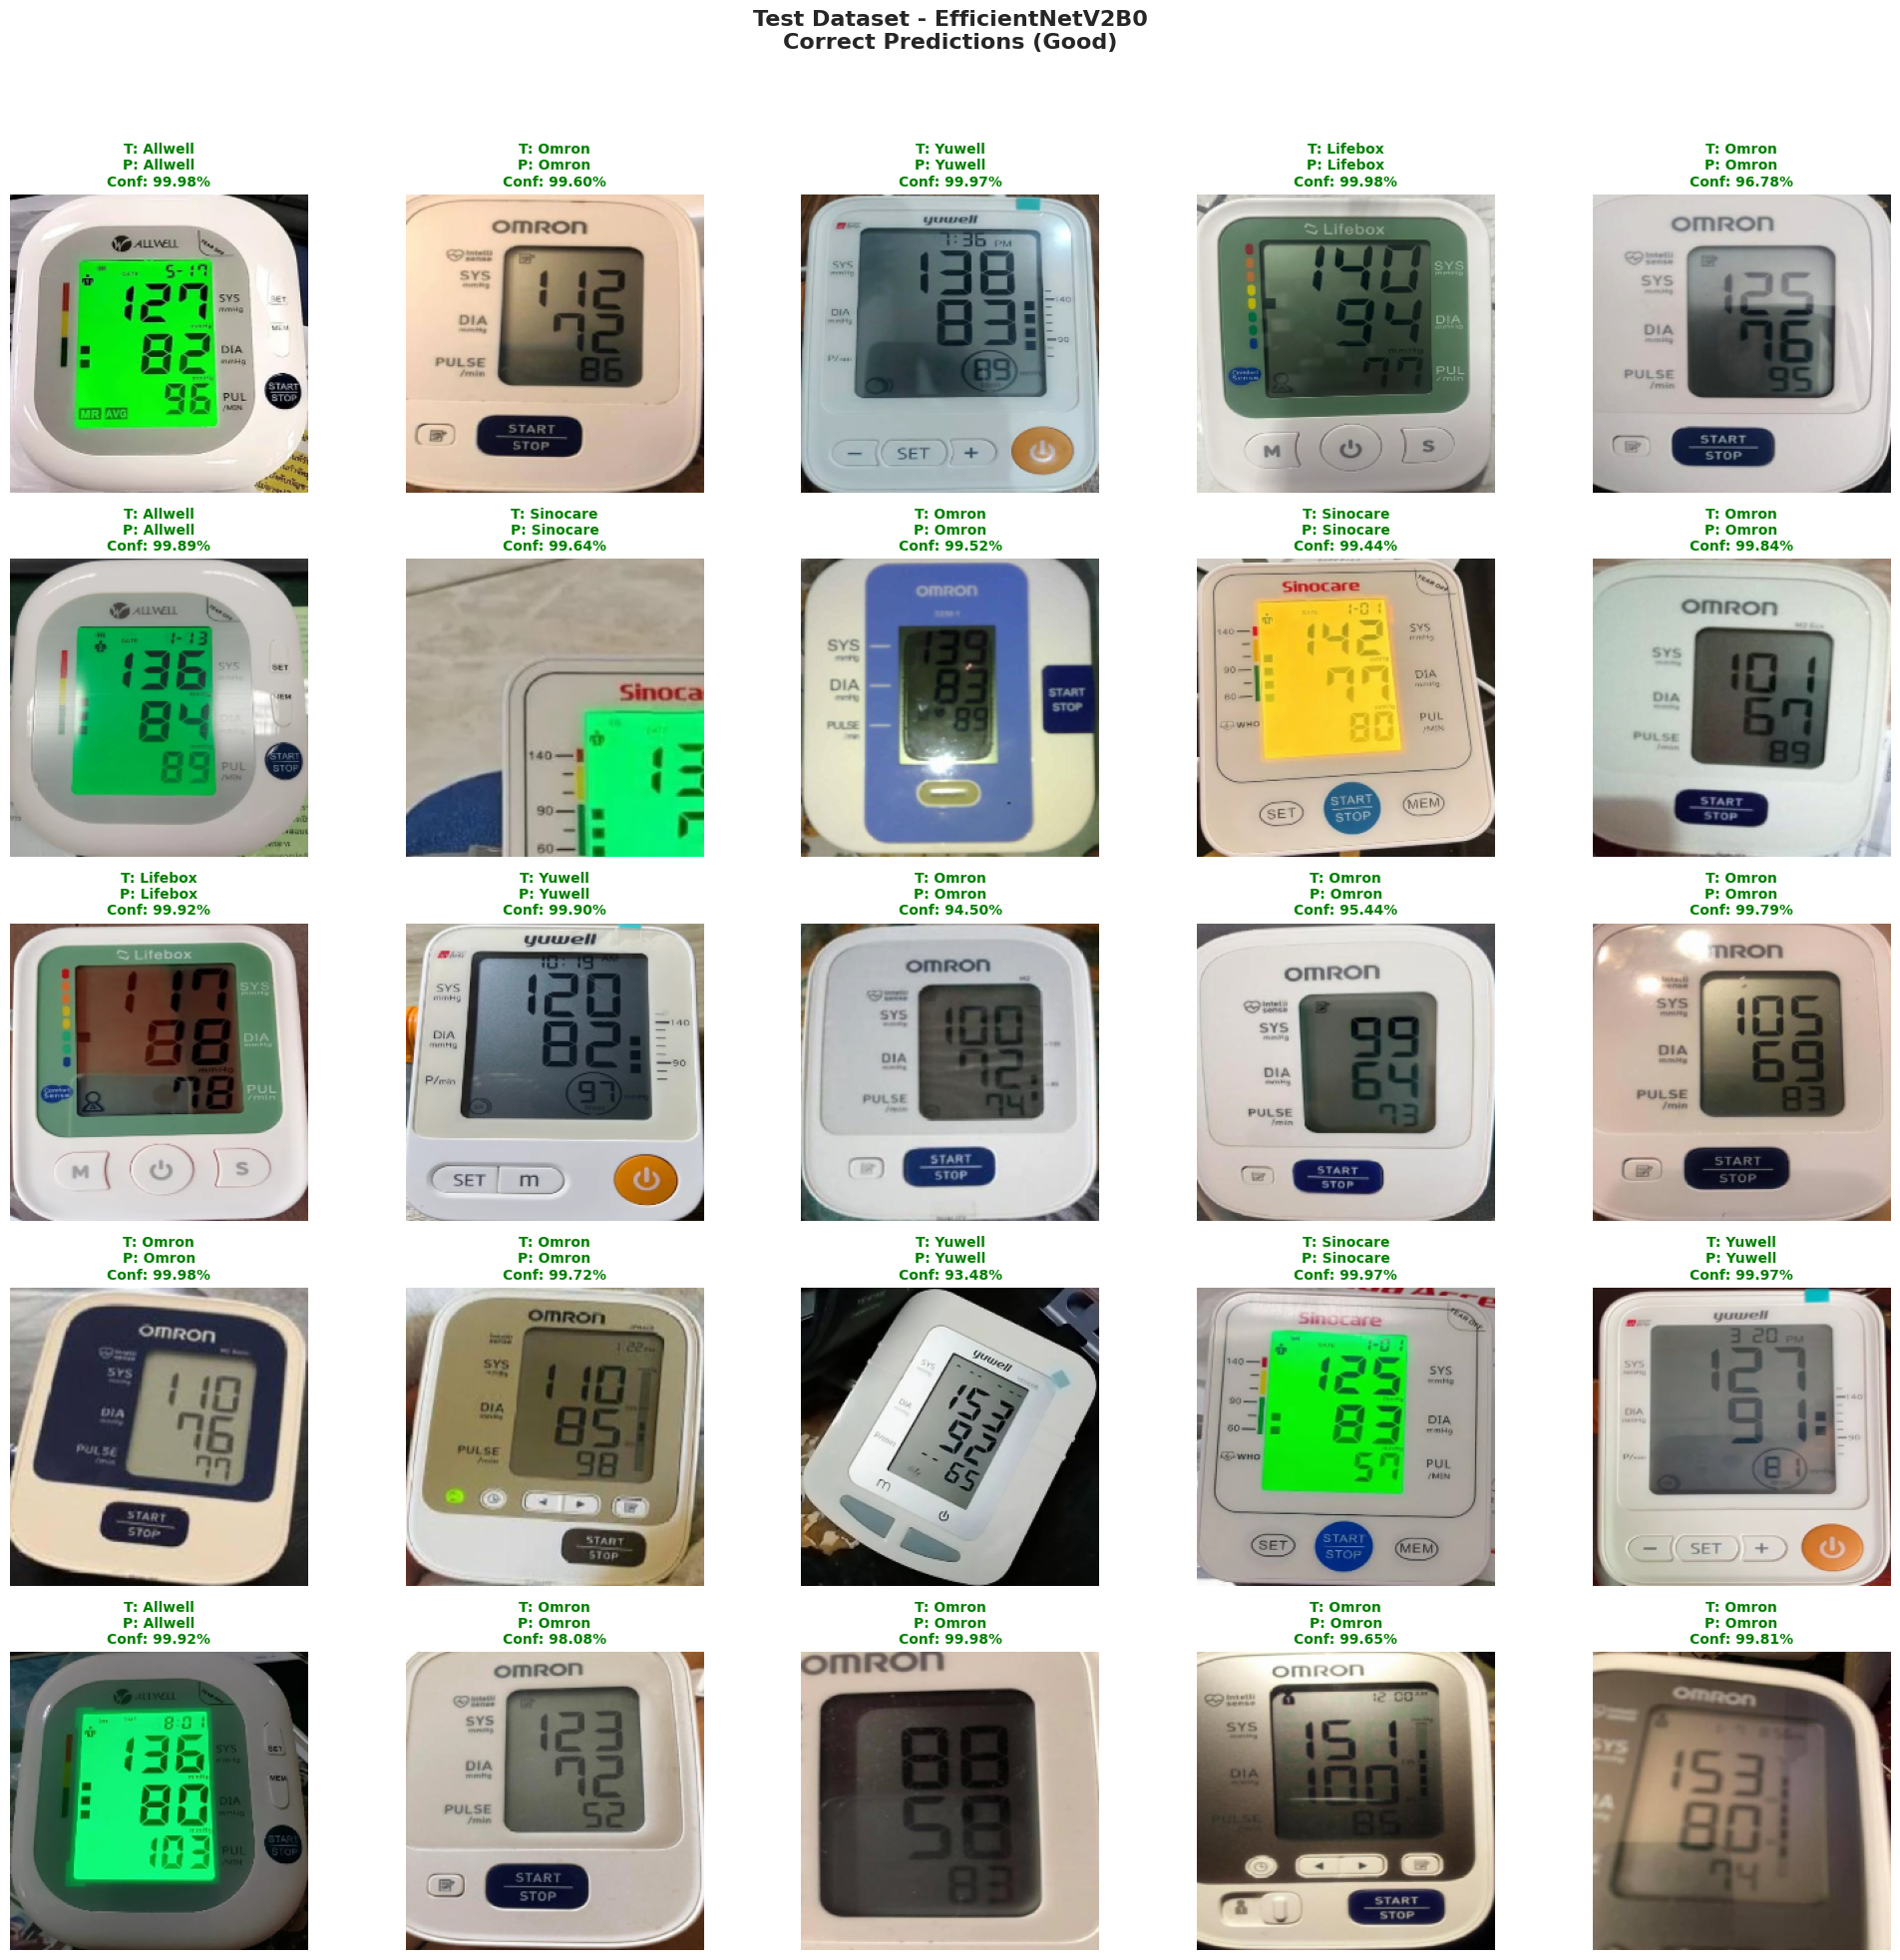

In [22]:
# Cell: Plot 5 Good Predictions Grid (Test)
def plot_prediction_grid(images, true_labels, pred_labels, confidences, class_names, 
                         correct=True, n_samples=25, n_rows=5,
                         title_prefix="", save_path=None):
    """Plot a grid (5 x n) of predictions (correct or incorrect)."""

    # Filter correct or incorrect predictions
    if correct:
        mask = true_labels == pred_labels
        grid_title = f"{title_prefix}Correct Predictions (Good)"
    else:
        mask = true_labels != pred_labels
        grid_title = f"{title_prefix}Incorrect Predictions (Bad)"

    filtered_indices = np.where(mask)[0]

    if len(filtered_indices) == 0:
        print(f"No {'correct' if correct else 'incorrect'} predictions found.")
        return

    # Sample
    n_to_show = min(n_samples, len(filtered_indices))
    sampled_indices = np.random.choice(filtered_indices, n_to_show, replace=False)

    # ---- GRID SIZE ----
    n_cols = int(np.ceil(n_to_show / n_rows))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, 4 * n_rows)
    )
    axes = np.array(axes).reshape(-1)

    for ax, idx in zip(axes, sampled_indices):
        img = images[idx]

        # Normalize for display
        if img.min() < 0 or img.max() > 1:
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        ax.imshow(img)
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]
        conf = confidences[idx]

        color = 'green' if correct else 'red'
        ax.set_title(
            f"T: {true_class}\nP: {pred_class}\nConf: {conf:.2%}",
            fontsize=10, color=color, fontweight='bold'
        )
        ax.axis('off')

    # Hide unused subplots
    for ax in axes[len(sampled_indices):]:
        ax.axis('off')

    plt.suptitle(grid_title, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# Plot good predictions
if 'test_images_viz' in dir() and len(test_images_viz) > 0:
    plot_prediction_grid(
        test_images_viz, test_true_viz, test_pred_viz, test_conf_viz, 
        class_names, correct=True, n_samples=25,
        title_prefix=f"Test Dataset - {best_model_name}\n",
        save_path="test_good_predictions_grid.png"
    )
else:
    print("No test images available for visualization.")

In [23]:
# Cell: Plot 5 Bad Predictions Grid (Test)
if 'test_images_viz' in dir() and len(test_images_viz) > 0:
    figures_dir = get_figures_dir(best_model_name)
    plot_prediction_grid(
        test_images_viz, test_true_viz, test_pred_viz, test_conf_viz, 
        class_names, correct=False, n_samples=5, 
        title_prefix=f"Test Dataset - {best_model_name}\n",
        save_path=figures_dir / "test_bad_predictions_grid.png"
    )
    print(f"Saved to: {figures_dir}")
else:
    print("No test images available for visualization.")

No incorrect predictions found.
Saved to: results/EfficientNetV2B0/figures


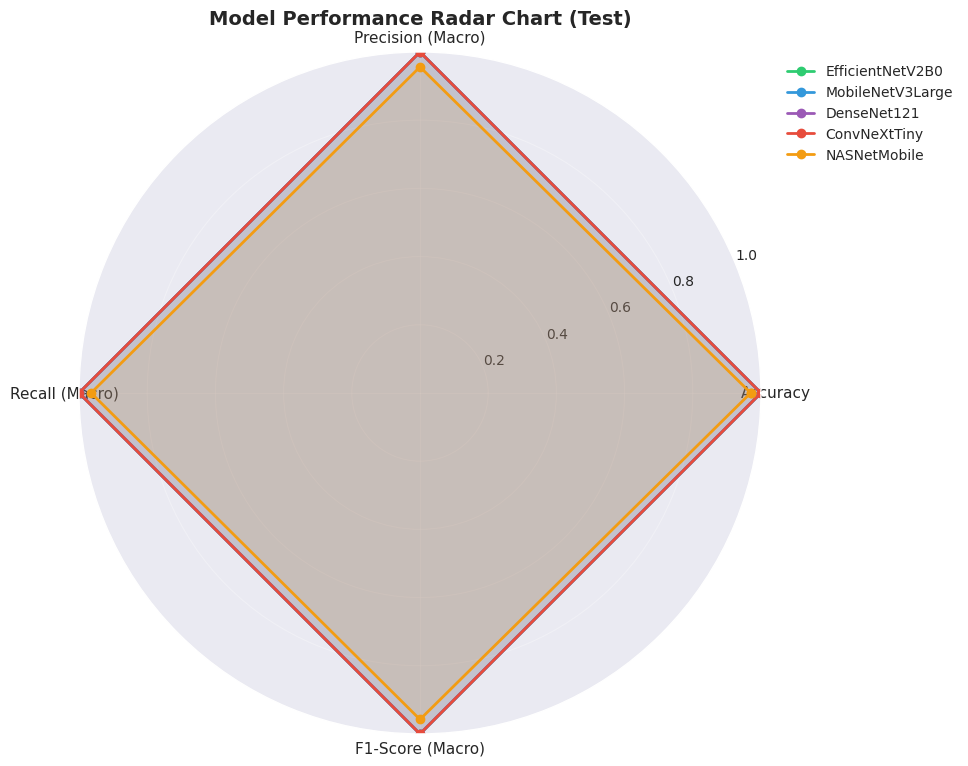

Saved to: results/_comparison


In [24]:
# Cell: Test Radar Chart
comparison_dir = get_comparison_dir()

if any("test_accuracy" in all_metrics[m] for m in model_names):
    # Build test metrics dataframe for radar chart
    test_radar_data = []
    for model_name in model_names:
        metrics = all_metrics[model_name]
        if "test_accuracy" in metrics:
            test_radar_data.append({
                "Model": model_name,
                "Accuracy": metrics["test_accuracy"],
                "Precision (Macro)": metrics["test_precision_macro"],
                "Recall (Macro)": metrics["test_recall_macro"],
                "F1-Score (Macro)": metrics["test_f1_macro"],
            })
    
    if test_radar_data:
        test_radar_df = pd.DataFrame(test_radar_data).set_index("Model")
        plot_radar_chart(test_radar_df, list(test_radar_df.index), 
                        title_suffix="Test", save_path=comparison_dir / "test_radar_chart_comparison.png")
        print(f"Saved to: {comparison_dir}")
else:
    print("No test metrics available for radar chart.")

### Training Time Comparison

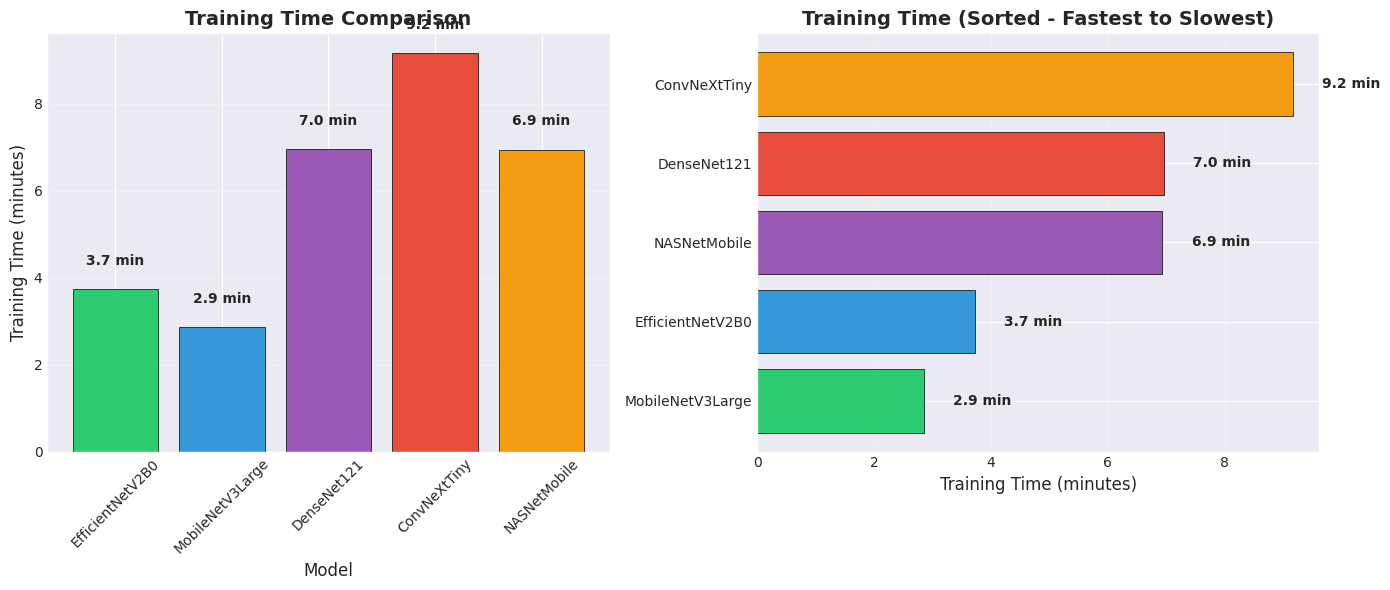


TRAINING TIME SUMMARY
MobileNetV3Large    :   2.85 minutes (171 seconds)
EfficientNetV2B0    :   3.73 minutes (224 seconds)
NASNetMobile        :   6.93 minutes (416 seconds)
DenseNet121         :   6.95 minutes (417 seconds)
ConvNeXtTiny        :   9.16 minutes (550 seconds)

Saved to: results/_comparison


In [25]:
# Cell 18: Training Time Comparison
comparison_dir = get_comparison_dir()
training_times = {model: all_metrics[model]["training_time_minutes"] for model in model_names}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']

# Bar chart for training time
bars = axes[0].bar(model_names, list(training_times.values()), color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Training Time (minutes)', fontsize=12)
axes[0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, time_val in zip(bars, training_times.values()):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{time_val:.1f} min', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Horizontal bar chart sorted by time
sorted_times = dict(sorted(training_times.items(), key=lambda x: x[1]))
y_pos = np.arange(len(sorted_times))
bars2 = axes[1].barh(y_pos, list(sorted_times.values()), color=colors[:len(sorted_times)], edgecolor='black', linewidth=0.5)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(list(sorted_times.keys()))
axes[1].set_xlabel('Training Time (minutes)', fontsize=12)
axes[1].set_title('Training Time (Sorted - Fastest to Slowest)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for bar, time_val in zip(bars2, sorted_times.values()):
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                 f'{time_val:.1f} min', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(comparison_dir / "train_training_time_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# Print training times
print("\n" + "="*50)
print("TRAINING TIME SUMMARY")
print("="*50)
for model, time_min in sorted(training_times.items(), key=lambda x: x[1]):
    print(f"{model:20s}: {time_min:6.2f} minutes ({time_min*60:.0f} seconds)")
print(f"\nSaved to: {comparison_dir}")

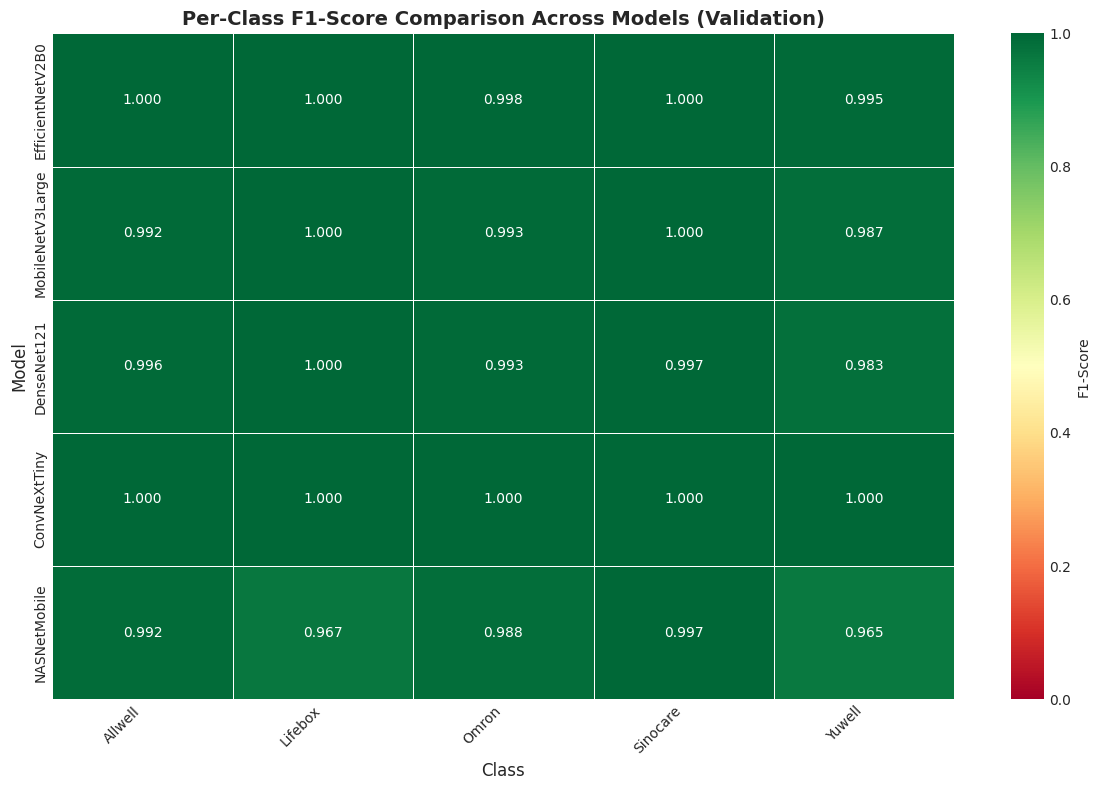


Per-Class F1-Score (Validation):
                   Allwell  Lifebox     Omron  Sinocare    Yuwell
EfficientNetV2B0  1.000000  1.00000  0.998008  1.000000  0.994975
MobileNetV3Large  0.992188  1.00000  0.993007  1.000000  0.987469
DenseNet121       0.996047  1.00000  0.993007  0.997455  0.982544
ConvNeXtTiny      1.000000  1.00000  1.000000  1.000000  1.000000
NASNetMobile      0.992063  0.96732  0.988048  0.997442  0.964824

Saved to: results/_comparison


In [26]:
# Cell 19: Per-Class Performance Comparison Heatmap (Validation)
comparison_dir = get_comparison_dir()

# Create per-class F1-score heatmap
per_class_f1 = []
for model in model_names:
    f1_values = [all_metrics[model][f"f1_{cls}"] for cls in class_names]
    per_class_f1.append(f1_values)

per_class_df = pd.DataFrame(per_class_f1, index=model_names, columns=class_names)

plt.figure(figsize=(12, 8))
sns.heatmap(per_class_df, annot=True, fmt='.3f', cmap='RdYlGn', 
            linewidths=0.5, vmin=0, vmax=1, cbar_kws={'label': 'F1-Score'})
plt.title('Per-Class F1-Score Comparison Across Models (Validation)', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(comparison_dir / "valid_per_class_f1_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

# Save CSV
per_class_df.to_csv(comparison_dir / "valid_per_class_f1_scores.csv")

print("\nPer-Class F1-Score (Validation):")
print(per_class_df.to_string())
print(f"\nSaved to: {comparison_dir}")

### Comprehensive Summary Table and Final Comparison

In [27]:
# Cell 20: Comprehensive Summary Table
comparison_dir = get_comparison_dir()

summary_data = []
for model_name in model_names:
    metrics = all_metrics[model_name]
    summary_data.append({
        "Model": model_name,
        "Accuracy": f"{metrics['accuracy']:.4f}",
        "Precision": f"{metrics['precision_macro']:.4f}",
        "Recall": f"{metrics['recall_macro']:.4f}",
        "F1-Score": f"{metrics['f1_macro']:.4f}",
        "Training Time (min)": f"{metrics['training_time_minutes']:.2f}",
        "Input Size": str(MODEL_CONFIG[model_name]["input_size"])
    })

summary_df = pd.DataFrame(summary_data)

# Style the dataframe for display
print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

# Save to CSV
summary_df.to_csv(comparison_dir / "comprehensive_model_comparison.csv", index=False)
print(f"\nResults saved to {comparison_dir / 'comprehensive_model_comparison.csv'}")

# Find best model for each metric
print("\n" + "-"*60)
print("BEST MODEL FOR EACH METRIC:")
print("-"*60)

# Convert back to float for comparison
float_summary = summary_df.copy()
float_summary["Accuracy"] = float_summary["Accuracy"].astype(float)
float_summary["Precision"] = float_summary["Precision"].astype(float)
float_summary["Recall"] = float_summary["Recall"].astype(float)
float_summary["F1-Score"] = float_summary["F1-Score"].astype(float)
float_summary["Training Time (min)"] = float_summary["Training Time (min)"].astype(float)

best_accuracy = float_summary.loc[float_summary["Accuracy"].idxmax()]
best_precision = float_summary.loc[float_summary["Precision"].idxmax()]
best_recall = float_summary.loc[float_summary["Recall"].idxmax()]
best_f1 = float_summary.loc[float_summary["F1-Score"].idxmax()]
fastest = float_summary.loc[float_summary["Training Time (min)"].idxmin()]

print(f"Best Accuracy:    {best_accuracy['Model']} ({best_accuracy['Accuracy']:.4f})")
print(f"Best Precision:   {best_precision['Model']} ({best_precision['Precision']:.4f})")
print(f"Best Recall:      {best_recall['Model']} ({best_recall['Recall']:.4f})")
print(f"Best F1-Score:    {best_f1['Model']} ({best_f1['F1-Score']:.4f})")
print(f"Fastest Training: {fastest['Model']} ({fastest['Training Time (min)']:.2f} min)")
print("-"*60)


COMPREHENSIVE MODEL COMPARISON SUMMARY
           Model Accuracy Precision Recall F1-Score Training Time (min) Input Size
EfficientNetV2B0   0.9982    0.9986 0.9986   0.9986                3.73 (224, 224)
MobileNetV3Large   0.9936    0.9931 0.9960   0.9945                2.85 (224, 224)
     DenseNet121   0.9927    0.9932 0.9944   0.9938                6.95 (224, 224)
    ConvNeXtTiny   1.0000    1.0000 1.0000   1.0000                9.16 (224, 224)
    NASNetMobile   0.9845    0.9803 0.9837   0.9819                6.93 (224, 224)

Results saved to results/_comparison/comprehensive_model_comparison.csv

------------------------------------------------------------
BEST MODEL FOR EACH METRIC:
------------------------------------------------------------
Best Accuracy:    ConvNeXtTiny (1.0000)
Best Precision:   ConvNeXtTiny (1.0000)
Best Recall:      ConvNeXtTiny (1.0000)
Best F1-Score:    ConvNeXtTiny (1.0000)
Fastest Training: MobileNetV3Large (2.85 min)
--------------------------------

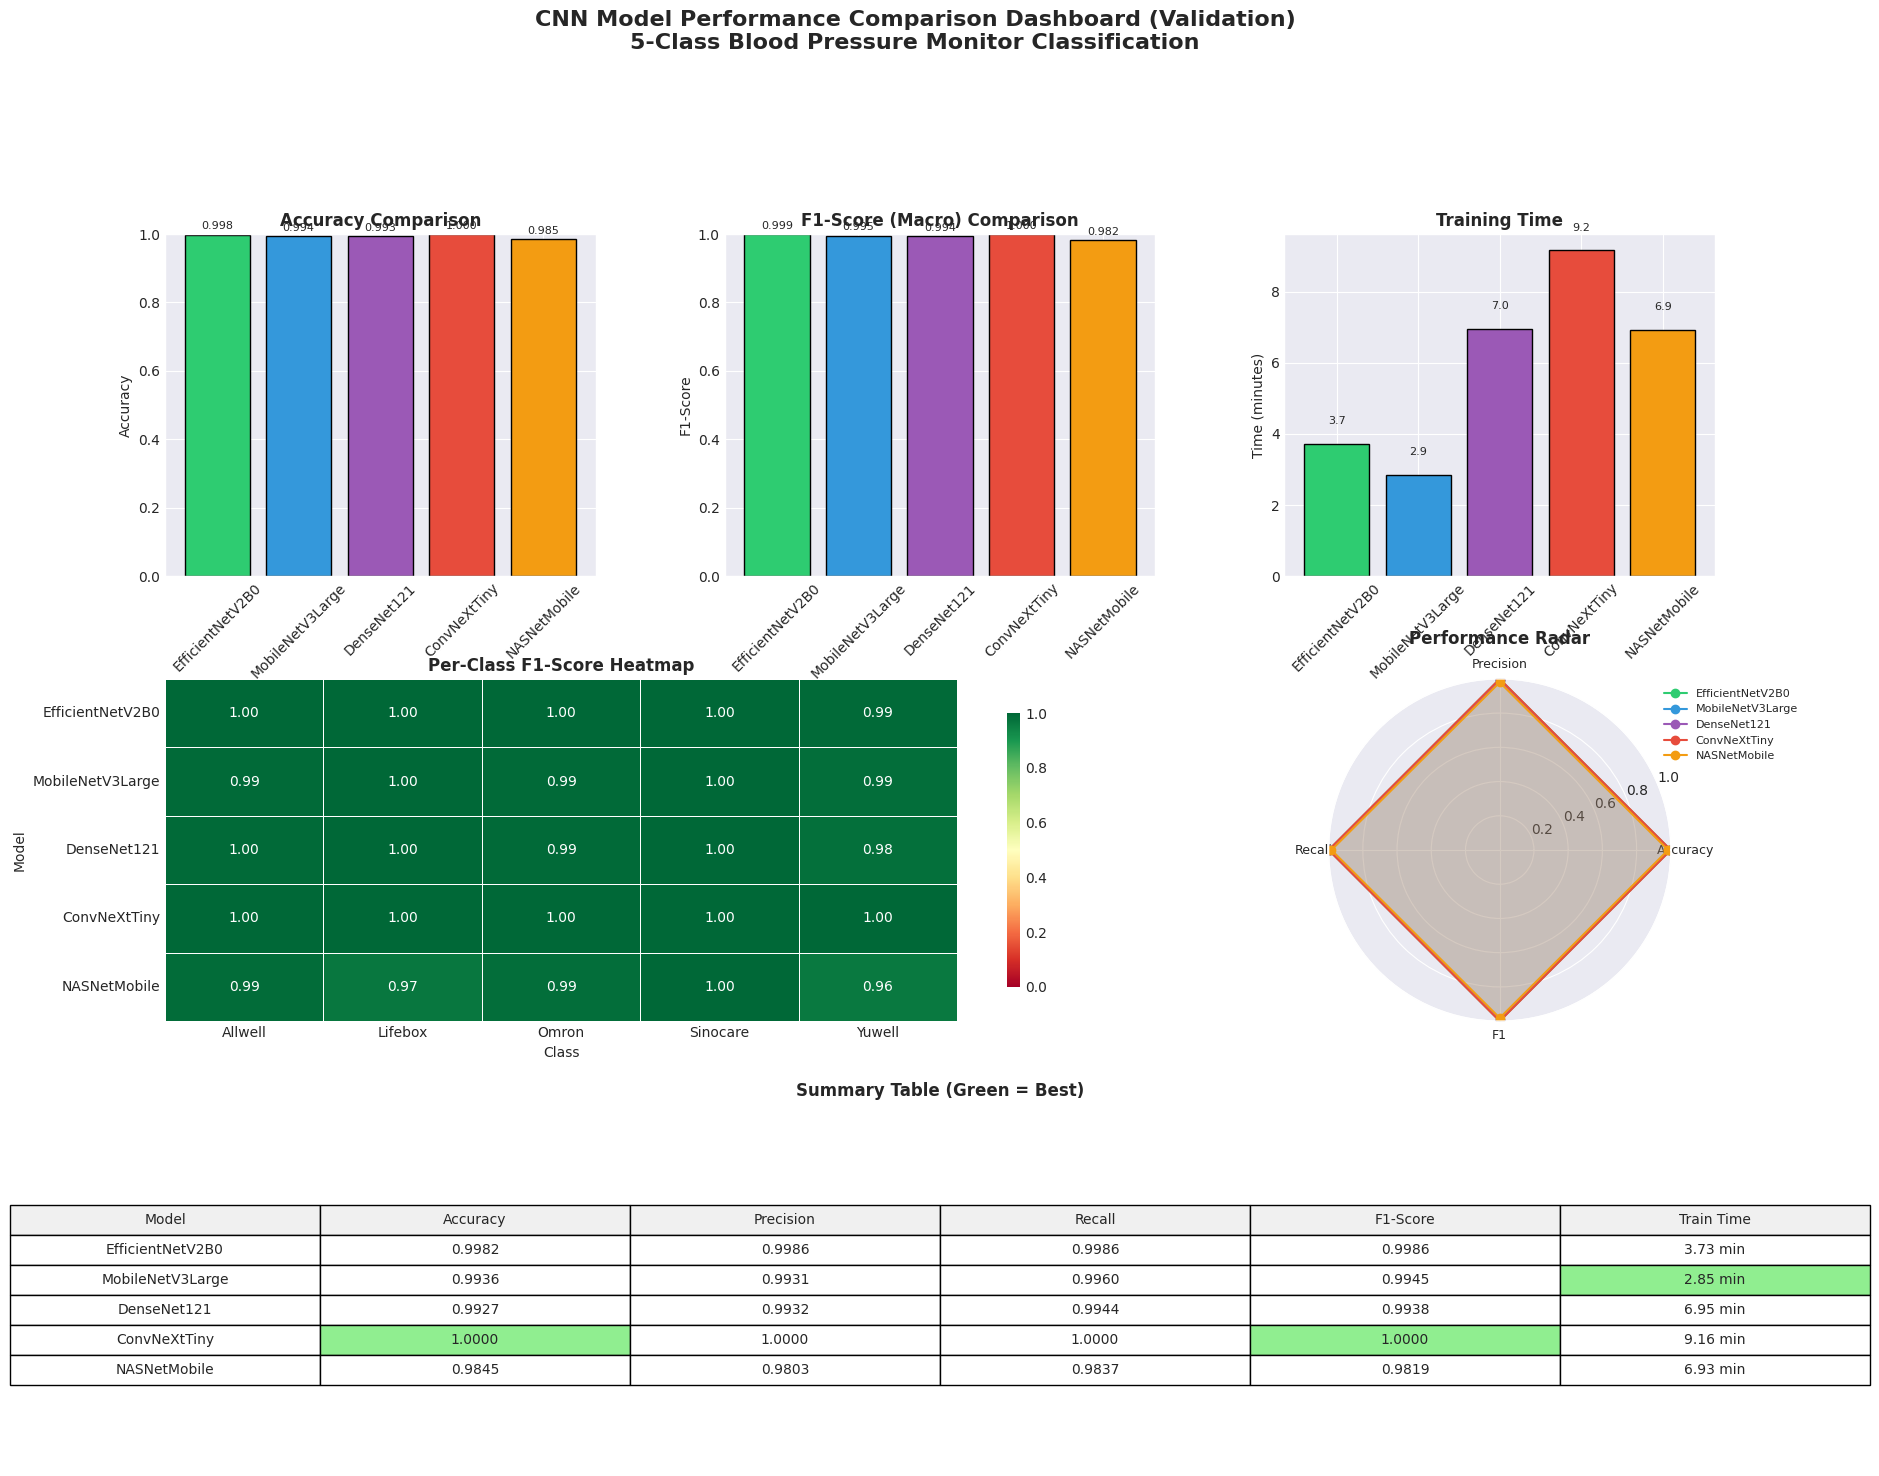

Saved to: results/_comparison


In [28]:
# Cell 21: Final Visualization - Combined Dashboard (Validation)
comparison_dir = get_comparison_dir()

fig = plt.figure(figsize=(20, 16))

# Create grid layout
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Bar chart - Accuracy comparison
ax1 = fig.add_subplot(gs[0, 0])
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']
accuracies = [all_metrics[m]["accuracy"] for m in model_names]
bars = ax1.bar(model_names, accuracies, color=colors, edgecolor='black')
ax1.set_ylabel('Accuracy', fontsize=10)
ax1.set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.tick_params(axis='x', rotation=45)
for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Bar chart - F1-Score comparison
ax2 = fig.add_subplot(gs[0, 1])
f1_scores = [all_metrics[m]["f1_macro"] for m in model_names]
bars = ax2.bar(model_names, f1_scores, color=colors, edgecolor='black')
ax2.set_ylabel('F1-Score', fontsize=10)
ax2.set_title('F1-Score (Macro) Comparison', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.tick_params(axis='x', rotation=45)
for bar, f1 in zip(bars, f1_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{f1:.3f}', ha='center', va='bottom', fontsize=8)

# 3. Training time comparison
ax3 = fig.add_subplot(gs[0, 2])
times = [all_metrics[m]["training_time_minutes"] for m in model_names]
bars = ax3.bar(model_names, times, color=colors, edgecolor='black')
ax3.set_ylabel('Time (minutes)', fontsize=10)
ax3.set_title('Training Time', fontsize=12, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
for bar, t in zip(bars, times):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{t:.1f}', ha='center', va='bottom', fontsize=8)

# 4. Per-class F1 heatmap
ax4 = fig.add_subplot(gs[1, :2])
per_class_f1_data = []
for model in model_names:
    f1_values = [all_metrics[model][f"f1_{cls}"] for cls in class_names]
    per_class_f1_data.append(f1_values)
per_class_df = pd.DataFrame(per_class_f1_data, index=model_names, columns=class_names)
sns.heatmap(per_class_df, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax4, 
            linewidths=0.5, vmin=0, vmax=1, cbar_kws={'shrink': 0.8})
ax4.set_title('Per-Class F1-Score Heatmap', fontsize=12, fontweight='bold')
ax4.set_xlabel('Class', fontsize=10)
ax4.set_ylabel('Model', fontsize=10)

# 5. Radar chart
ax5 = fig.add_subplot(gs[1, 2], polar=True)
categories = ["Accuracy", "Precision", "Recall", "F1"]
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

for idx, model in enumerate(model_names):
    values = [
        all_metrics[model]["accuracy"],
        all_metrics[model]["precision_macro"],
        all_metrics[model]["recall_macro"],
        all_metrics[model]["f1_macro"]
    ]
    values += values[:1]
    ax5.plot(angles, values, 'o-', linewidth=1.5, label=model, color=colors[idx])
    ax5.fill(angles, values, alpha=0.1, color=colors[idx])

ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(categories, fontsize=9)
ax5.set_ylim(0, 1)
ax5.set_title('Performance Radar', fontsize=12, fontweight='bold', pad=10)
ax5.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0), fontsize=8)

# 6. Summary table as plot
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')
table_data = []
for model in model_names:
    table_data.append([
        model,
        f"{all_metrics[model]['accuracy']:.4f}",
        f"{all_metrics[model]['precision_macro']:.4f}",
        f"{all_metrics[model]['recall_macro']:.4f}",
        f"{all_metrics[model]['f1_macro']:.4f}",
        f"{all_metrics[model]['training_time_minutes']:.2f} min"
    ])

table = ax6.table(cellText=table_data,
                  colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Train Time'],
                  loc='center',
                  cellLoc='center',
                  colColours=['#f0f0f0']*6)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.8)

# Highlight best values
for i, model in enumerate(model_names):
    if all_metrics[model]["accuracy"] == max(all_metrics[m]["accuracy"] for m in model_names):
        table[(i+1, 1)].set_facecolor('#90EE90')
    if all_metrics[model]["f1_macro"] == max(all_metrics[m]["f1_macro"] for m in model_names):
        table[(i+1, 4)].set_facecolor('#90EE90')
    if all_metrics[model]["training_time_minutes"] == min(all_metrics[m]["training_time_minutes"] for m in model_names):
        table[(i+1, 5)].set_facecolor('#90EE90')

ax6.set_title('Summary Table (Green = Best)', fontsize=12, fontweight='bold', pad=20)

plt.suptitle('CNN Model Performance Comparison Dashboard (Validation)\n5-Class Blood Pressure Monitor Classification', 
             fontsize=16, fontweight='bold', y=1.02)
plt.savefig(comparison_dir / "valid_model_comparison_dashboard.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved to: {comparison_dir}")

In [29]:
# Cell 22: Export All Results to CSV Files
comparison_dir = get_comparison_dir()

# Export comprehensive results
comprehensive_data = []
for model_name in model_names:
    metrics = all_metrics[model_name]
    row = {
        "Model": model_name,
        "Accuracy": metrics["accuracy"],
        "Precision_Macro": metrics["precision_macro"],
        "Recall_Macro": metrics["recall_macro"],
        "F1_Score_Macro": metrics["f1_macro"],
        "Precision_Weighted": metrics["precision_weighted"],
        "Recall_Weighted": metrics["recall_weighted"],
        "F1_Score_Weighted": metrics["f1_weighted"],
        "Training_Time_Seconds": metrics["training_time_seconds"],
        "Training_Time_Minutes": metrics["training_time_minutes"],
        "Input_Size": str(MODEL_CONFIG[model_name]["input_size"]),
    }
    if "test_accuracy" in metrics:
        row["Test_Accuracy"] = metrics["test_accuracy"]
        row["Test_Precision_Macro"] = metrics["test_precision_macro"]
        row["Test_Recall_Macro"] = metrics["test_recall_macro"]
        row["Test_F1_Score_Macro"] = metrics["test_f1_macro"]
        row["Test_Precision_Weighted"] = metrics["test_precision_weighted"]
        row["Test_Recall_Weighted"] = metrics["test_recall_weighted"]
        row["Test_F1_Score_Weighted"] = metrics["test_f1_weighted"]
    for cls in class_names:
        row[f"Precision_{cls}"] = metrics[f"precision_{cls}"]
        row[f"Recall_{cls}"] = metrics[f"recall_{cls}"]
        row[f"F1_{cls}"] = metrics[f"f1_{cls}"]
        test_precision_key = f"test_precision_{cls}"
        test_recall_key = f"test_recall_{cls}"
        test_f1_key = f"test_f1_{cls}"
        if test_precision_key in metrics:
            row[f"Test_Precision_{cls}"] = metrics[test_precision_key]
        if test_recall_key in metrics:
            row[f"Test_Recall_{cls}"] = metrics[test_recall_key]
        if test_f1_key in metrics:
            row[f"Test_F1_{cls}"] = metrics[test_f1_key]
    comprehensive_data.append(row)

comprehensive_df = pd.DataFrame(comprehensive_data)
comprehensive_df.to_csv(comparison_dir / "all_model_metrics_detailed.csv", index=False)

has_test_metrics = any("test_f1_macro" in all_metrics[m] for m in model_names)

print("=" * 80)
print("RESULTS STRUCTURE")
print("=" * 80)
print(f"\n📁 Results Directory: {RESULTS_DIR.resolve()}")
print("\n📂 Per-Model Outputs:")
for model_name in model_names:
    print(f"\n  {model_name}/")
    print(f"    ├── models/")
    print(f"    │   ├── best_{model_name}.keras")
    print(f"    │   └── best_{model_name}_finetuned.keras")
    print(f"    ├── figures/")
    print(f"    │   ├── train_{model_name}_history.png")
    print(f"    │   └── valid_{model_name}_confusion_matrix_normalized.png")
    if has_test_metrics:
        print(f"    │   └── test_{model_name}_confusion_matrix_normalized.png")
    print(f"    └── reports/")
    print(f"        ├── valid_{model_name}_summary_metrics.csv")
    print(f"        └── valid_{model_name}_per_class_metrics.csv")
    if has_test_metrics:
        print(f"        ├── test_{model_name}_summary_metrics.csv")
        print(f"        └── test_{model_name}_per_class_metrics.csv")

print(f"\n? _comparison/  (Multi-model comparison outputs)")
print(f"    ├── all_model_metrics_detailed.csv")
print(f"    ├── comprehensive_model_comparison.csv")
print(f"    ├── valid_all_confusion_matrices_normalized.png")
print(f"    ├── valid_performance_metrics_comparison.png")
print(f"    ├── valid_radar_chart_comparison.png")
print(f"    ├── valid_per_class_f1_heatmap.png")
print(f"    ├── valid_per_class_f1_scores.csv")
print(f"    ├── valid_all_models_metrics_comparison.csv")
print(f"    ├── valid_model_comparison_dashboard.png")
print(f"    ├── train_training_time_comparison.png")
if has_test_metrics:
    print(f"    ├── test_all_confusion_matrices_normalized.png")
    print(f"    ├── test_performance_metrics_comparison.png")
    print(f"    ├── test_metrics_table.png")
    print(f"    ├── test_metrics_comparison.csv")
    print(f"    ├── test_per_class_f1_heatmap.png")
    print(f"    ├── test_per_class_f1_scores.csv")
    print(f"    ├── test_radar_chart_comparison.png")
    print(f"    └── test_all_models_metrics_comparison.csv")

print("\n" + "=" * 80)

RESULTS STRUCTURE

📁 Results Directory: /home/vanthkrab/PycharmProjects/BP-Monitor/learning/cnn/lab4-2/results

📂 Per-Model Outputs:

  EfficientNetV2B0/
    ├── models/
    │   ├── best_EfficientNetV2B0.keras
    │   └── best_EfficientNetV2B0_finetuned.keras
    ├── figures/
    │   ├── train_EfficientNetV2B0_history.png
    │   └── valid_EfficientNetV2B0_confusion_matrix_normalized.png
    │   └── test_EfficientNetV2B0_confusion_matrix_normalized.png
    └── reports/
        ├── valid_EfficientNetV2B0_summary_metrics.csv
        └── valid_EfficientNetV2B0_per_class_metrics.csv
        ├── test_EfficientNetV2B0_summary_metrics.csv
        └── test_EfficientNetV2B0_per_class_metrics.csv

  MobileNetV3Large/
    ├── models/
    │   ├── best_MobileNetV3Large.keras
    │   └── best_MobileNetV3Large_finetuned.keras
    ├── figures/
    │   ├── train_MobileNetV3Large_history.png
    │   └── valid_MobileNetV3Large_confusion_matrix_normalized.png
    │   └── test_MobileNetV3Large_confusion_ma

## Inference / Prediction Examples

In [30]:
# Cell 14: Prediction Function
def predict_image(model, image_path, model_name, class_names):
    """Predict class for a single image."""
    config = MODEL_CONFIG[model_name]
    input_size = config["input_size"]
    preprocess_fn = config["preprocess"]
    
    # Load and preprocess image
    img = keras.utils.load_img(image_path, target_size=input_size)
    img_array = keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    if preprocess_fn:
        img_array = preprocess_fn(img_array)
    
    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    
    # Display
    plt.figure(figsize=(8, 6))
    plt.imshow(keras.utils.load_img(image_path))
    plt.title(f"Predicted: {class_names[predicted_class_idx]} ({confidence:.2%})")
    plt.axis("off")
    plt.show()
    
    return class_names[predicted_class_idx], confidence

In [31]:
# Load models to predict


In [32]:
# Cell 15: Load Saved Model and Make Predictions
# Load the best model (example with EfficientNetV2B0)
# loaded_model = keras.models.load_model("best_EfficientNetV2B0_finetuned.keras")

# Alternative: Train a single model quickly for testing
def quick_train_single_model(model_name, epochs=5, fine_tune_epochs=3):
    """Quick training for testing purposes."""
    print(f"\n{'='*60}")
    print(f"Quick Training: {model_name}")
    print(f"{'='*60}")
    
    config = MODEL_CONFIG[model_name]
    input_size = config["input_size"]
    preprocess_fn = config["preprocess"]
    
    train_ds, val_ds, test_ds, class_names = load_dataset(input_size, preprocess_fn)
    
    build_fn = MODEL_BUILDERS[model_name]
    model, base_model = build_fn(NUM_CLASSES, input_size)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Quick training
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1
    )
    
    # Quick fine-tuning
    base_model.trainable = True
    fine_tune_at = len(base_model.layers) // 2
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    history2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=fine_tune_epochs,
        verbose=1
    )
    
    # Save model
    model.save(f"quick_{model_name}.keras")
    print(f"Model saved as quick_{model_name}.keras")
    
    return model, class_names

# Uncomment to run quick training:
# quick_model, class_names = quick_train_single_model("MobileNetV3Large")

## Export Models for FastAPI Deployment

In [33]:
# Export Models to Multiple Formats for FastAPI Deployment
# Supports: Keras (.keras), SavedModel, ONNX, TFLite

import shutil


def export_model_to_formats(model_path: Path, model_name: str, export_formats: list = None):
    """
    Export a trained Keras model to multiple formats for deployment.

    Args:
        model_path: Path to the .keras model file
        model_name: Name of the model (e.g., "EfficientNetV2B0")
        export_formats: List of formats to export. Options: ["savedmodel", "onnx", "tflite"]
                       If None, exports all formats.

    Returns:
        dict: Paths to exported models
    """
    if export_formats is None:
        export_formats = ["savedmodel", "onnx", "tflite"]

    export_dir = RESULTS_DIR / model_name / "exports"
    export_dir.mkdir(parents=True, exist_ok=True)

    exported_paths = {}

    # Load the model
    print(f"\n{'='*60}")
    print(f"Exporting {model_name} from: {model_path}")
    print(f"{'='*60}")

    try:
        model = keras.models.load_model(model_path)
        print(f"✓ Model loaded successfully")
    except Exception as e:
        print(f"✗ Failed to load model: {e}")
        return exported_paths

    # 1. Copy original Keras format
    try:
        keras_export_path = export_dir / f"{model_name}.keras"
        shutil.copy2(model_path, keras_export_path)
        exported_paths["keras"] = keras_export_path
        print(f"✓ Keras format: {keras_export_path}")
    except Exception as e:
        print(f"✗ Failed to copy .keras file: {e}")

    # 2. Export to SavedModel format (TensorFlow SavedModel)
    if "savedmodel" in export_formats:
        try:
            savedmodel_path = export_dir / f"{model_name}_savedmodel"
            # Use Keras model.save to export SavedModel
            model.save(str(savedmodel_path), save_format="tf")
            exported_paths["savedmodel"] = savedmodel_path
            print(f"✓ SavedModel format: {savedmodel_path}")
        except Exception as e:
            print(f"✗ SavedModel export failed: {e}")

    # 3. Export to ONNX format (cross-platform inference)
    if "onnx" in export_formats:
        try:
            import tf2onnx
            import onnx

            onnx_path = export_dir / f"{model_name}.onnx"

            # Convert to ONNX using tf2onnx
            # tf2onnx.from_keras can simplify conversion, but use convert.from_keras for compatibility
            try:
                spec = (tf.TensorSpec(model.inputs[0].shape, tf.float32, name="input"),)
            except Exception:
                spec = None

            if spec is not None:
                model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, output_path=str(onnx_path))
            else:
                model_proto, _ = tf2onnx.convert.from_keras(model, output_path=str(onnx_path))

            exported_paths["onnx"] = onnx_path
            print(f"✓ ONNX format: {onnx_path}")
        except ImportError:
            print(f"⚠ ONNX export skipped: Install tf2onnx with 'pip install tf2onnx onnx'")
        except Exception as e:
            print(f"✗ ONNX export failed: {e}")

    # 4. Export to TFLite format (mobile/edge deployment)
    if "tflite" in export_formats:
        try:
            tflite_path = export_dir / f"{model_name}.tflite"

            # Convert to TFLite
            converter = tf.lite.TFLiteConverter.from_keras_model(model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            tflite_model = converter.convert()

            # Save TFLite model
            with open(tflite_path, 'wb') as f:
                f.write(tflite_model)

            exported_paths["tflite"] = tflite_path
            print(f"✓ TFLite format: {tflite_path}")

            # Also create quantized version
            try:
                tflite_quant_path = export_dir / f"{model_name}_quantized.tflite"
                converter_quant = tf.lite.TFLiteConverter.from_keras_model(model)
                converter_quant.optimizations = [tf.lite.Optimize.DEFAULT]
                converter_quant.target_spec.supported_types = [tf.float16]
                tflite_quant_model = converter_quant.convert()

                with open(tflite_quant_path, 'wb') as f:
                    f.write(tflite_quant_model)

                exported_paths["tflite_quantized"] = tflite_quant_path
                print(f"✓ TFLite (float16 quantized): {tflite_quant_path}")
            except Exception as e:
                print(f"⚠ TFLite quantized export failed: {e}")

        except Exception as e:
            print(f"✗ TFLite export failed: {e}")

    return exported_paths


def export_all_trained_models(export_formats: list = None, quick_test_format: str = "onnx"):
    """
    Export all trained models from results directory to multiple formats.

    Args:
        export_formats: List of formats to export. Options: ["savedmodel", "onnx", "tflite"]
                        If None, exports only the quick_test_format to speed up testing.
        quick_test_format: When export_formats is None, export this single format for a fast test run.

    Returns:
        dict: Dictionary of model names to their exported paths
    """
    all_exports = {}

    print("\n" + "="*70)
    print("EXPORTING ALL TRAINED MODELS FOR FASTAPI DEPLOYMENT")
    print("="*70)

    # Determine formats to run
    if export_formats is None:
        export_formats = [quick_test_format]

    # Find all trained models
    for model_name in MODEL_CONFIG.keys():
        model_dir = RESULTS_DIR / model_name / "models"

        if not model_dir.exists():
            print(f"\n⚠ No models found for {model_name}")
            continue

        # Look for finetuned model first, then base model
        finetuned_path = model_dir / f"best_{model_name}_finetuned.keras"
        base_path = model_dir / f"best_{model_name}.keras"

        if finetuned_path.exists():
            model_path = finetuned_path
        elif base_path.exists():
            model_path = base_path
        else:
            # Try to find any .keras file
            keras_files = list(model_dir.glob("*.keras"))
            if keras_files:
                model_path = keras_files[0]
            else:
                print(f"\n⚠ No .keras model found for {model_name}")
                continue

        exports = export_model_to_formats(model_path, model_name, export_formats)
        all_exports[model_name] = exports

    # Summary
    print("\n" + "="*70)
    print("EXPORT SUMMARY")
    print("="*70)

    for model_name, exports in all_exports.items():
        print(f"\n{model_name}:")
        for fmt, path in exports.items():
            size_mb = path.stat().st_size / (1024 * 1024) if Path(path).exists() else 0
            print(f"  - {fmt}: {path.name} ({size_mb:.2f} MB)")

    return all_exports


def create_fastapi_model_config():
    """
    Create a configuration file for FastAPI model loading.
    """
    config_path = RESULTS_DIR / "fastapi_config.json"

    config = {
        "models": {},
        "class_names": CLASS_NAMES,
        "input_size": [224, 224],
        "supported_formats": ["keras", "savedmodel", "onnx", "tflite"]
    }

    for model_name in MODEL_CONFIG.keys():
        export_dir = RESULTS_DIR / model_name / "exports"
        if export_dir.exists():
            model_files = {}

            # Check each format
            keras_path = export_dir / f"{model_name}.keras"
            if keras_path.exists():
                model_files["keras"] = str(keras_path.relative_to(RESULTS_DIR))

            savedmodel_path = export_dir / f"{model_name}_savedmodel"
            if savedmodel_path.exists():
                model_files["savedmodel"] = str(savedmodel_path.relative_to(RESULTS_DIR))

            onnx_path = export_dir / f"{model_name}.onnx"
            if onnx_path.exists():
                model_files["onnx"] = str(onnx_path.relative_to(RESULTS_DIR))

            tflite_path = export_dir / f"{model_name}.tflite"
            if tflite_path.exists():
                model_files["tflite"] = str(tflite_path.relative_to(RESULTS_DIR))

            if model_files:
                config["models"][model_name] = {
                    "files": model_files,
                    "preprocess": MODEL_CONFIG[model_name]["preprocess"].__name__ if MODEL_CONFIG[model_name]["preprocess"] else None,
                }

    import json
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)

    print(f"\n✓ FastAPI config saved: {config_path}")
    return config


# Print available formats info
print("Available Export Formats:")
print("-" * 40)
print("1. keras     - Native Keras format (.keras)")
print("2. savedmodel - TensorFlow SavedModel (TF Serving)")
print("3. onnx      - Open Neural Network Exchange")
print("4. tflite    - TensorFlow Lite (mobile/edge)")
print("-" * 40)
print("\nUsage:")
print("  export_all_trained_models()  # Quick test exports ONNX for each model")
print("  export_all_trained_models(['onnx', 'tflite'])  # Export ONNX and TFLite for all models")


Available Export Formats:
----------------------------------------
1. keras     - Native Keras format (.keras)
2. savedmodel - TensorFlow SavedModel (TF Serving)
3. onnx      - Open Neural Network Exchange
4. tflite    - TensorFlow Lite (mobile/edge)
----------------------------------------

Usage:
  export_all_trained_models()  # Quick test exports ONNX for each model
  export_all_trained_models(['onnx', 'tflite'])  # Export ONNX and TFLite for all models
